# Media Mix Modeling Analysis

**Introduction**

This notebook contains the detailed technical analysis for our Media Mix Modeling (MMM) project. It demonstrates the step-by-step process of building a robust model to understand the effectiveness of our marketing channels and optimize budget allocation.

**Note to readers:** This is a technical analysis notebook that shows the mathematical and statistical processes behind our media mix optimization. For business users seeking actionable insights and recommendations in a more accessible format, please refer to the companion "Media Mix Optimization Report" notebook.

**What this notebook covers:**

1. Data exploration and preparation
2. Correlation analysis between marketing channels and sales
3. Seasonal and economic factor analysis
4. Adstock transformation to capture carryover effects
5. Hill transformation to model diminishing returns
6. Ridge regression model building and validation
7. Budget allocation optimization for both ROI and sales maximization
8. Detailed model evaluation and diagnostics

The analysis in this notebook provides the foundation for all recommendations presented in the business-focused report. Data scientists and analysts can use this notebook to understand the methodology, validate the approach, and extend the model for future enhancements.

## Misc

In [301]:
%%html
<style>.container { width:95% !important; }</style>

Imports and styles

In [302]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.optimize import minimize
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12


Read in the data and display the first few rows

In [303]:
data.columns

Index(['Time_Period', 'TV_Spend', 'Digital_Spend', 'Radio_Spend',
       'Print_Spend', 'Total_Sales', 'Economic_Condition', 'Seasonal_Event',
       'Date', 'predicted_simple_ridge', 'TV_Spend_lag1', 'TV_Spend_lag2',
       'TV_Spend_lag3', 'Digital_Spend_lag1', 'Digital_Spend_lag2',
       'Digital_Spend_lag3', 'Radio_Spend_lag1', 'Radio_Spend_lag2',
       'Radio_Spend_lag3', 'Print_Spend_lag1', 'Print_Spend_lag2',
       'Print_Spend_lag3'],
      dtype='object')

In [304]:
# Read in the data
data = pd.read_csv('MMM_data.csv')[['Time_Period', 'TV_Spend', 'Digital_Spend','Radio_Spend', 'Print_Spend','Total_Sales','Economic_Condition','Seasonal_Event']]

# Display the first few rows
data.head()

,Time_Period,TV_Spend,Digital_Spend,Radio_Spend,Print_Spend,Total_Sales,Economic_Condition,Seasonal_Event
0,Jan 2017,20000,15000.0,5000,3000.0,103000.0,Stable,New Year
1,Feb 2017,19700,15225.0,4992,2996.0,113000.0,Stable,Valentine's Day
2,Mar 2017,20045,15293.0,4922,2973.0,110000.0,Stable,None
3,Apr 2017,19738,15024.0,4916,2911.0,112000.0,Stable,Easter
4,May 2017,19477,15047.0,5169,2874.0,113000.0,Stable,Memorial Day


## Initial Data Exploration

First, let's understand what our data looks like and check for any issues

In [305]:
# Basic information about the dataset
print("Dataset Shape:", data.shape)
print("\nData Types:")
display(pd.DataFrame(data.dtypes,columns=['Type']))

# Summary statistics
print("\nSummary Statistics:")
display(data.describe().applymap(lambda x: '{:,.0f}'.format(x)))

# Check for missing values
print("\nMissing Values:")
display(pd.DataFrame(data.isnull().sum(),columns=['Missing']))

# Economic Condition Distribution
print("\nEconomic Condition Distribution:")
display(data['Economic_Condition'].value_counts().reset_index().rename(columns={'index': 'Category', 'Economic_Condition': 'Count'}))

# Seasonal Event Distribution
print("\nSeasonal Event Distribution:")
display(data['Seasonal_Event'].value_counts().reset_index().rename(columns={'index': 'Category', 'Seasonal_Event': 'Count'}))

Dataset Shape: (60, 8)

Data Types:


,Type
Time_Period,object
TV_Spend,int64
Digital_Spend,float64
Radio_Spend,int64
Print_Spend,float64
Total_Sales,float64
Economic_Condition,object
Seasonal_Event,object



Summary Statistics:


,TV_Spend,Digital_Spend,Radio_Spend,Print_Spend,Total_Sales
count,60,60,60,60,60
mean,"22,219","20,010","5,314","2,832","136,750"
std,"2,532","4,005",516,253,"15,309"
min,"18,173","14,906","4,707","2,524","103,000"
25%,"20,635","16,759","5,029","2,688","127,000"
50%,"22,343","19,362","5,201","2,795","137,000"
75%,"23,445","22,790","5,481","2,906","148,000"
max,"32,133","29,408","7,659","4,034","175,000"



Missing Values:


,Missing
Time_Period,0
TV_Spend,0
Digital_Spend,0
Radio_Spend,0
Print_Spend,0
Total_Sales,0
Economic_Condition,0
Seasonal_Event,0



Economic Condition Distribution:


,Category,Count
0,Growth,28
1,Stable,24
2,Declining,8



Seasonal Event Distribution:


,Category,Count
0,None,15
1,New Year,5
2,Valentine's Day,5
3,Easter,5
4,Memorial Day,5
5,Independence Day,5
6,Labor Day,5
7,Halloween,5
8,Thanksgiving,5
9,Christmas,5


Let's visualize the sales trend over time

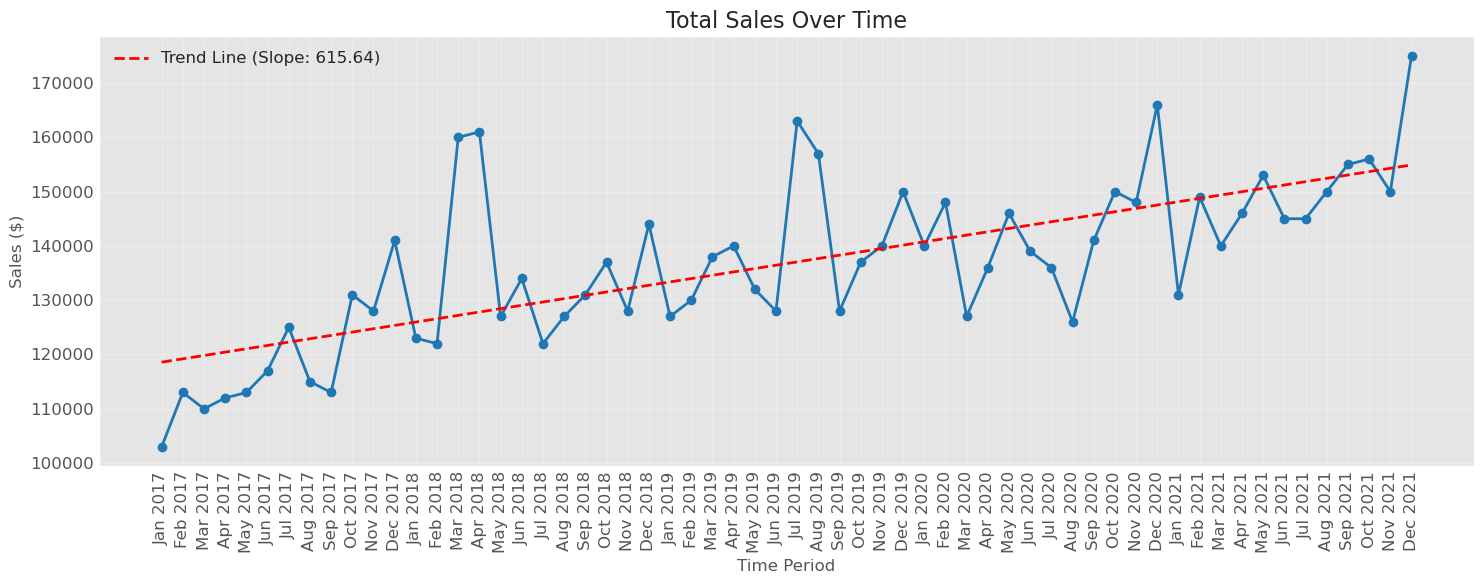

In [306]:
plt.figure(figsize=(15, 6))
plt.plot(data['Time_Period'], data['Total_Sales'], marker='o', linestyle='-', color='#1f77b4', linewidth=2)
plt.title('Total Sales Over Time', fontsize=16)
plt.xlabel('Time Period', fontsize=12)
plt.ylabel('Sales ($)', fontsize=12)
plt.xticks(rotation=90)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Add a trend line
z = np.polyfit(range(len(data)), data['Total_Sales'], 1)
p = np.poly1d(z)
plt.plot(data['Time_Period'], p(range(len(data))), linestyle='--', color='red', linewidth=2, label=f'Trend Line (Slope: {z[0]:.2f})')
plt.legend()
plt.show()

Summary of observations from initial exploration

In [307]:
print("\nInitial Observations:")
print("1. The dataset contains {} months of data.".format(len(data)))
print("2. There's a clear upward trend in sales over time.")
print("3. Sales show seasonal patterns with peaks and troughs.")
print("4. We need to investigate how media spend correlates with sales.")


Initial Observations:
1. The dataset contains 60 months of data.
2. There's a clear upward trend in sales over time.
3. Sales show seasonal patterns with peaks and troughs.
4. We need to investigate how media spend correlates with sales.


## Media Spend Patterns

Let's examine how media spend across channels has changed over time

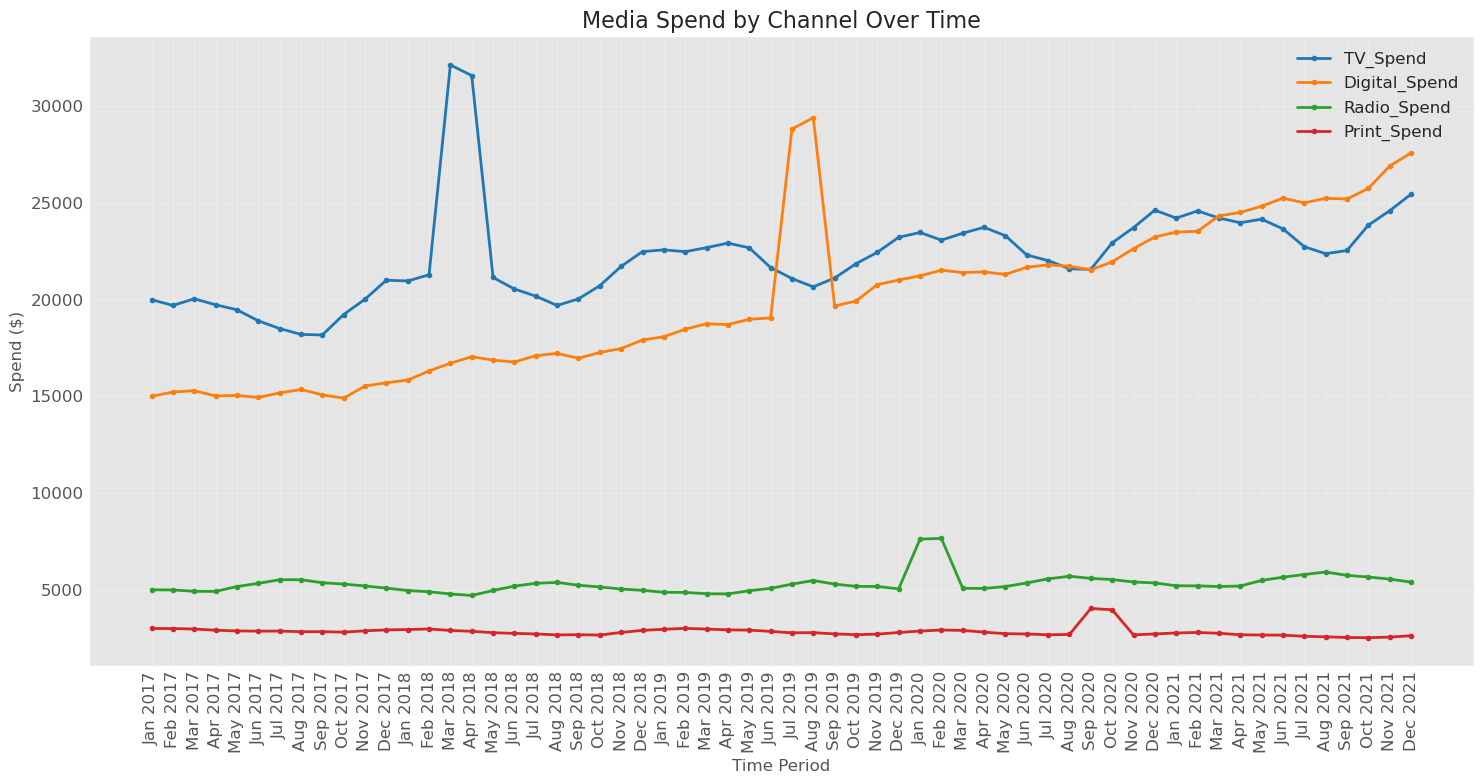

In [308]:
# Plot media spend by channel over time
plt.figure(figsize=(15, 8))
channels = ['TV_Spend', 'Digital_Spend', 'Radio_Spend', 'Print_Spend']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, channel in enumerate(channels):
    plt.plot(data['Time_Period'], data[channel], marker='.', label=channel, color=colors[i], linewidth=2)

plt.title('Media Spend by Channel Over Time', fontsize=16)
plt.xlabel('Time Period', fontsize=12)
plt.ylabel('Spend ($)', fontsize=12)
plt.xticks(rotation=90)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

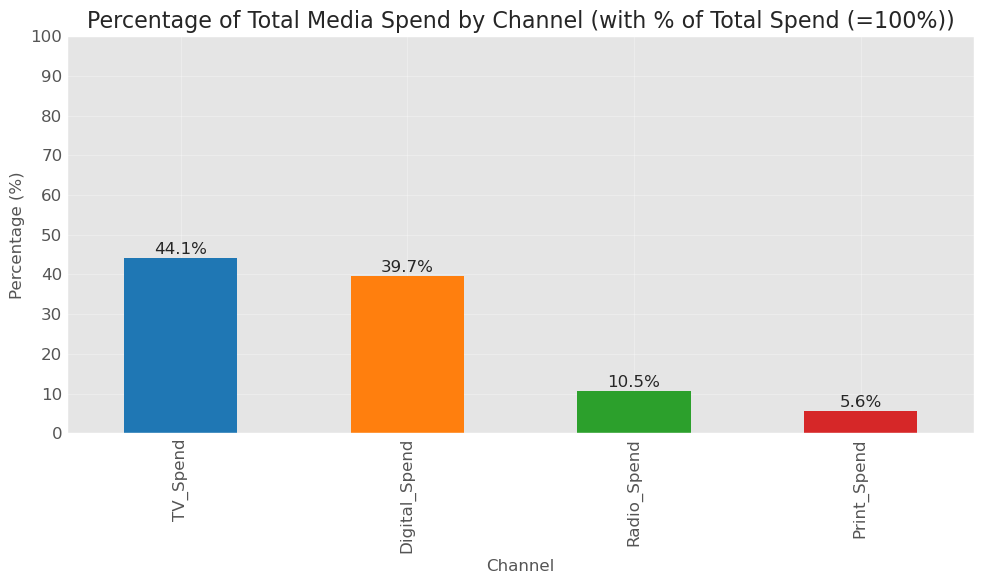

In [309]:
# Calculate and display the percentage of total spend for each channel
total_spend_by_channel = data[channels].sum()
percentage_by_channel = (total_spend_by_channel / total_spend_by_channel.sum()) * 100

plt.figure(figsize=(10, 6))
percentage_by_channel.plot(kind='bar', color=colors)
plt.title('Percentage of Total Media Spend by Channel (with % of Total Spend (=100%))', fontsize=16)
plt.xlabel('Channel', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.yticks(np.arange(0, 101, 10))

for i, percentage in enumerate(percentage_by_channel):
    plt.text(i, percentage + 1, f'{percentage:.1f}%', ha='center', fontsize=12)

plt.tight_layout()
plt.show()

Findings

In [310]:
print("\nRevised Observations on Media Spend Patterns:")
print("1. Digital spend has grown rapidly and overtook TV spend around late 2020.")
print("2. TV spend increased over time but at a slower rate compared to Digital spend.")
print("3. Radio spend has remained relatively stable with minor fluctuations.")
print("4. Print spend has gradually declined over time.")
print("5. TV still holds the largest share of total media spend, but Digital is very close behind.")


Revised Observations on Media Spend Patterns:
1. Digital spend has grown rapidly and overtook TV spend around late 2020.
2. TV spend increased over time but at a slower rate compared to Digital spend.
3. Radio spend has remained relatively stable with minor fluctuations.
4. Print spend has gradually declined over time.
5. TV still holds the largest share of total media spend, but Digital is very close behind.


## Correlation Analysis

Let's examine how different variables correlate with sales

In [311]:
# Calculate correlations between media channels and sales
correlation = data[channels + ['Total_Sales']].corr()

# Display correlation with sales
print("Correlation with Total Sales:")
display(pd.DataFrame(correlation['Total_Sales'].sort_values(ascending=False)).rename(columns={'Total_Sales': 'Correlation'}))

Correlation with Total Sales:


,Correlation
Total_Sales,1.000000
Digital_Spend,0.747840
TV_Spend,0.689559
Radio_Spend,0.217819
Print_Spend,-0.160074


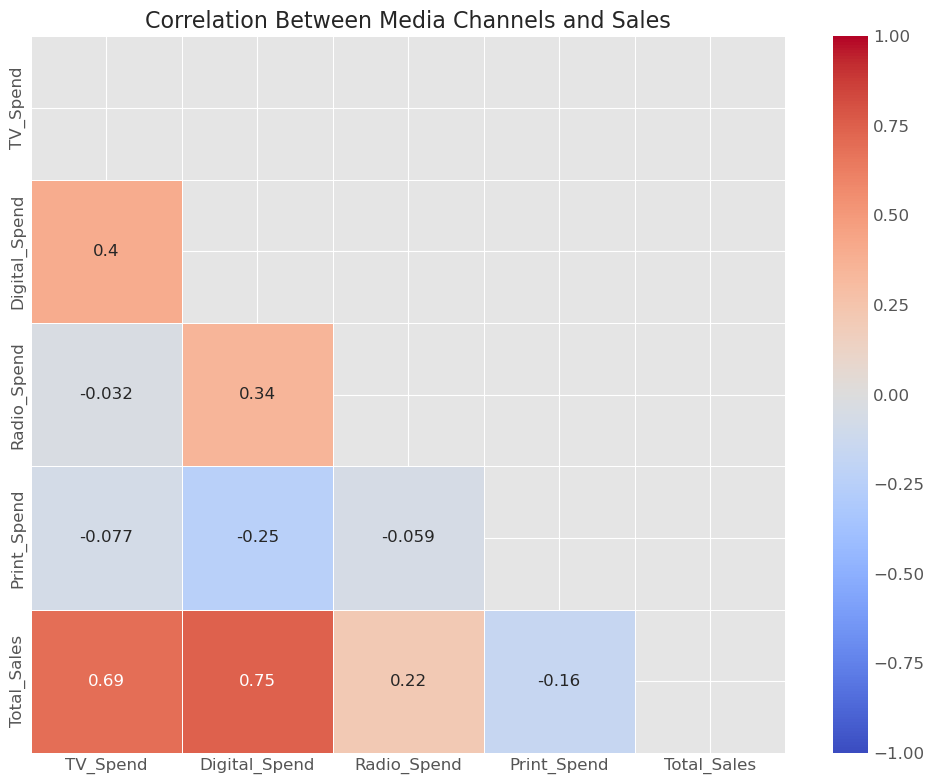

In [312]:
# Create a correlation heatmap
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation, dtype=bool))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, mask=mask, linewidths=0.5)
plt.title('Correlation Between Media Channels and Sales', fontsize=16)
plt.tight_layout()
plt.show()

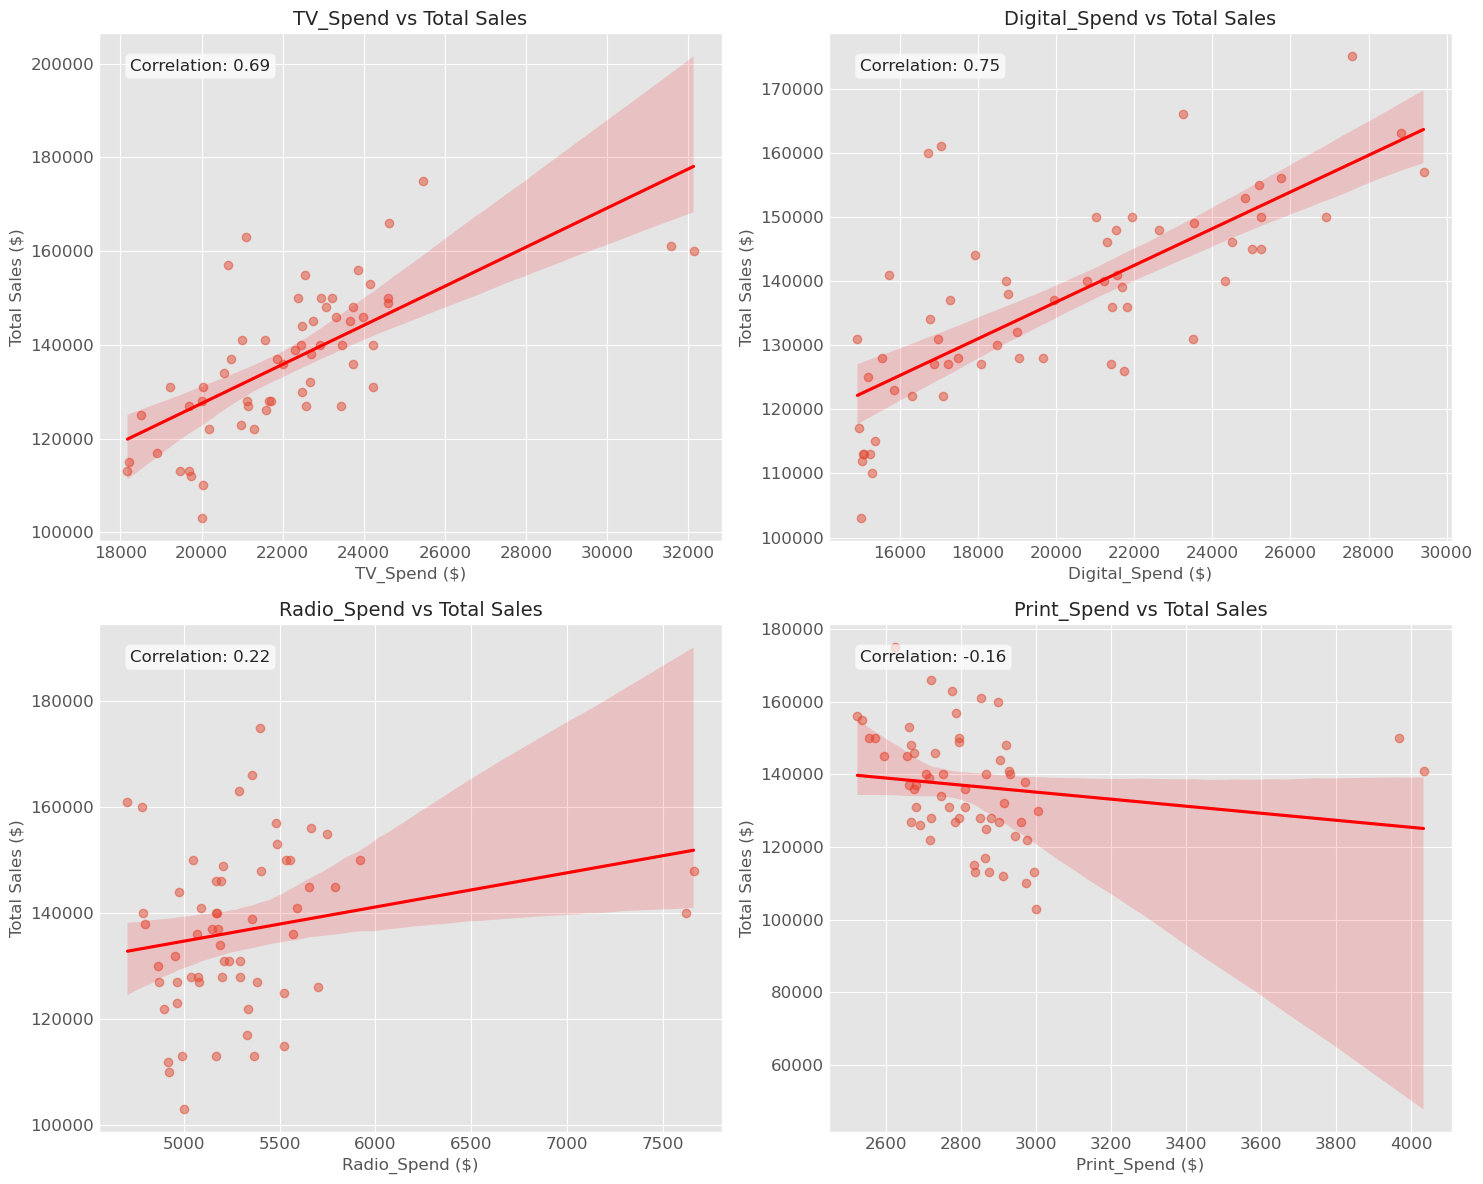

In [313]:
# Create scatter plots for each channel vs sales
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, channel in enumerate(channels):
    sns.regplot(x=channel, y='Total_Sales', data=data, ax=axes[i], 
                scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    axes[i].set_title(f'{channel} vs Total Sales', fontsize=14)
    axes[i].set_xlabel(f'{channel} ($)', fontsize=12)
    axes[i].set_ylabel('Total Sales ($)', fontsize=12)
    
    # Calculate and display Pearson correlation
    corr = data[[channel, 'Total_Sales']].corr().iloc[0,1]
    axes[i].annotate(f'Correlation: {corr:.2f}', 
                     xy=(0.05, 0.95), xycoords='axes fraction',
                     ha='left', va='top', fontsize=12,
                     bbox=dict(boxstyle='round', fc='white', alpha=0.7))
    
plt.tight_layout()
plt.show()

Findings

In [314]:
print("\nKey Findings from Correlation Analysis:")
print("1. Digital spend shows the strongest positive correlation with sales.")
print("2. TV spend also has a strong positive correlation with sales.")
print("3. We observe some large outliers which is confirmed with the business that these were experiments they conducted.")
print("4. Simple correlation analysis doesn't account for other factors like seasonality or economic conditions.")


Key Findings from Correlation Analysis:
1. Digital spend shows the strongest positive correlation with sales.
2. TV spend also has a strong positive correlation with sales.
3. We observe some large outliers which is confirmed with the business that these were experiments they conducted.
4. Simple correlation analysis doesn't account for other factors like seasonality or economic conditions.


## Seasonal and Economic Effects

Let's examine how seasonal events and economic conditions affect sales

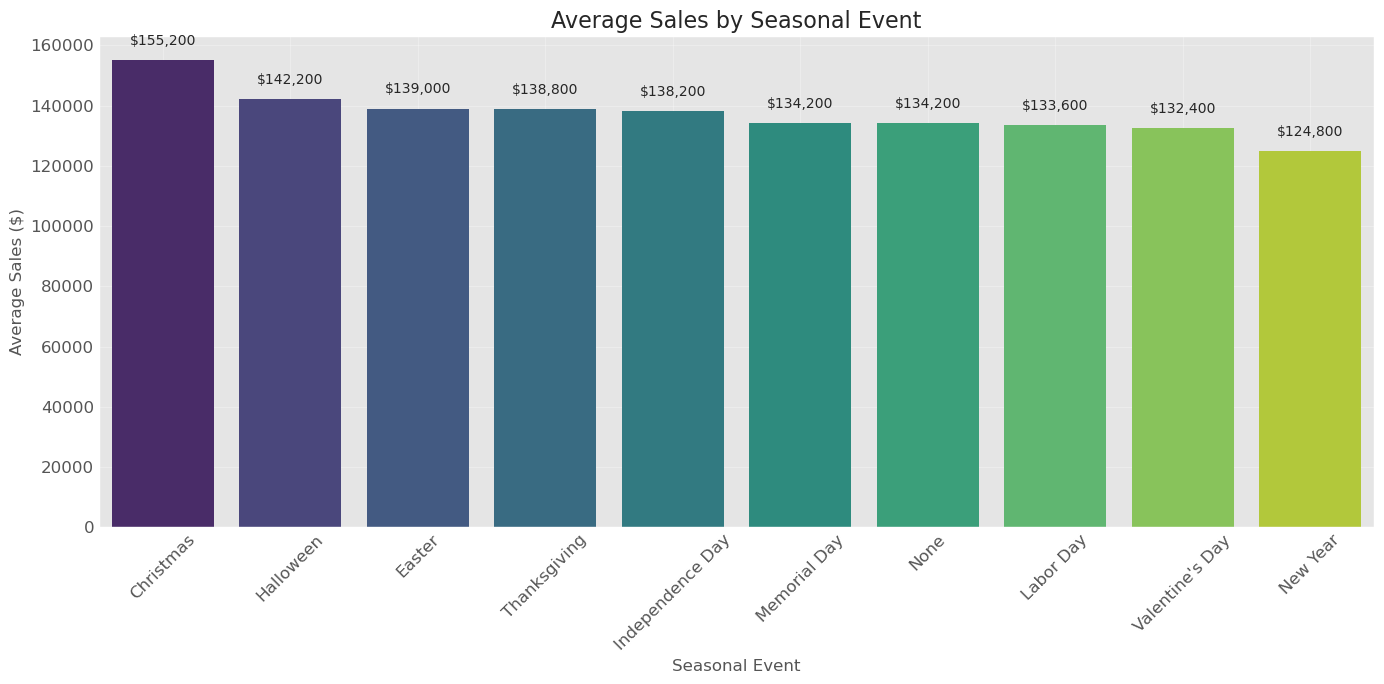

In [315]:
plt.figure(figsize=(14, 7))
event_means = data.groupby('Seasonal_Event')['Total_Sales'].mean().sort_values(ascending=False)
event_counts = data.groupby('Seasonal_Event').size()

# Filter out events with too few occurrences for reliable analysis
event_means = event_means[event_counts >= 2]

sns.barplot(x=event_means.index, y=event_means.values, palette='viridis')
plt.title('Average Sales by Seasonal Event', fontsize=16)
plt.xlabel('Seasonal Event', fontsize=12)
plt.ylabel('Average Sales ($)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Add value labels on top of bars
for i, v in enumerate(event_means.values.round(0)):
    plt.text(i, v + 5000, f'${v:,.0f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

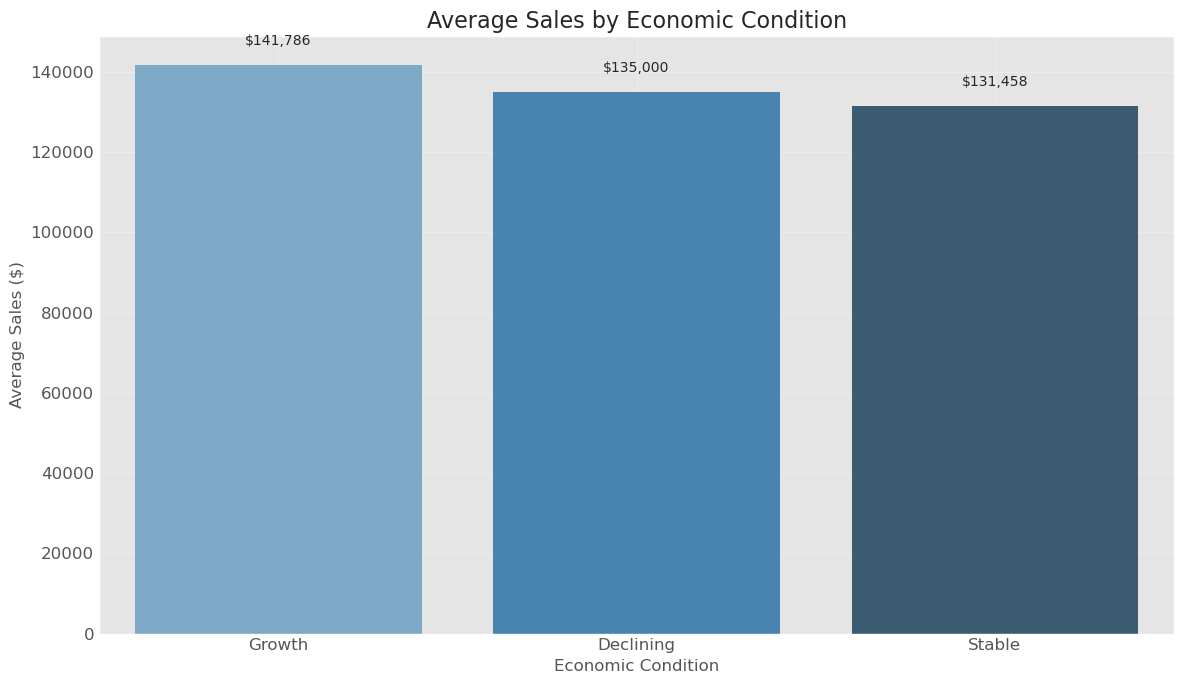

In [316]:
# Economic Condition Analysis
plt.figure(figsize=(12, 7))
econ_means = data.groupby('Economic_Condition')['Total_Sales'].mean().sort_values(ascending=False)

sns.barplot(x=econ_means.index, y=econ_means.values, palette='Blues_d')
plt.title('Average Sales by Economic Condition', fontsize=16)
plt.xlabel('Economic Condition', fontsize=12)
plt.ylabel('Average Sales ($)', fontsize=12)
plt.grid(True, alpha=0.3)

# Add value labels on top of bars
for i, v in enumerate(econ_means.values.round(0)):
    plt.text(i, v + 5000, f'${v:,.0f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

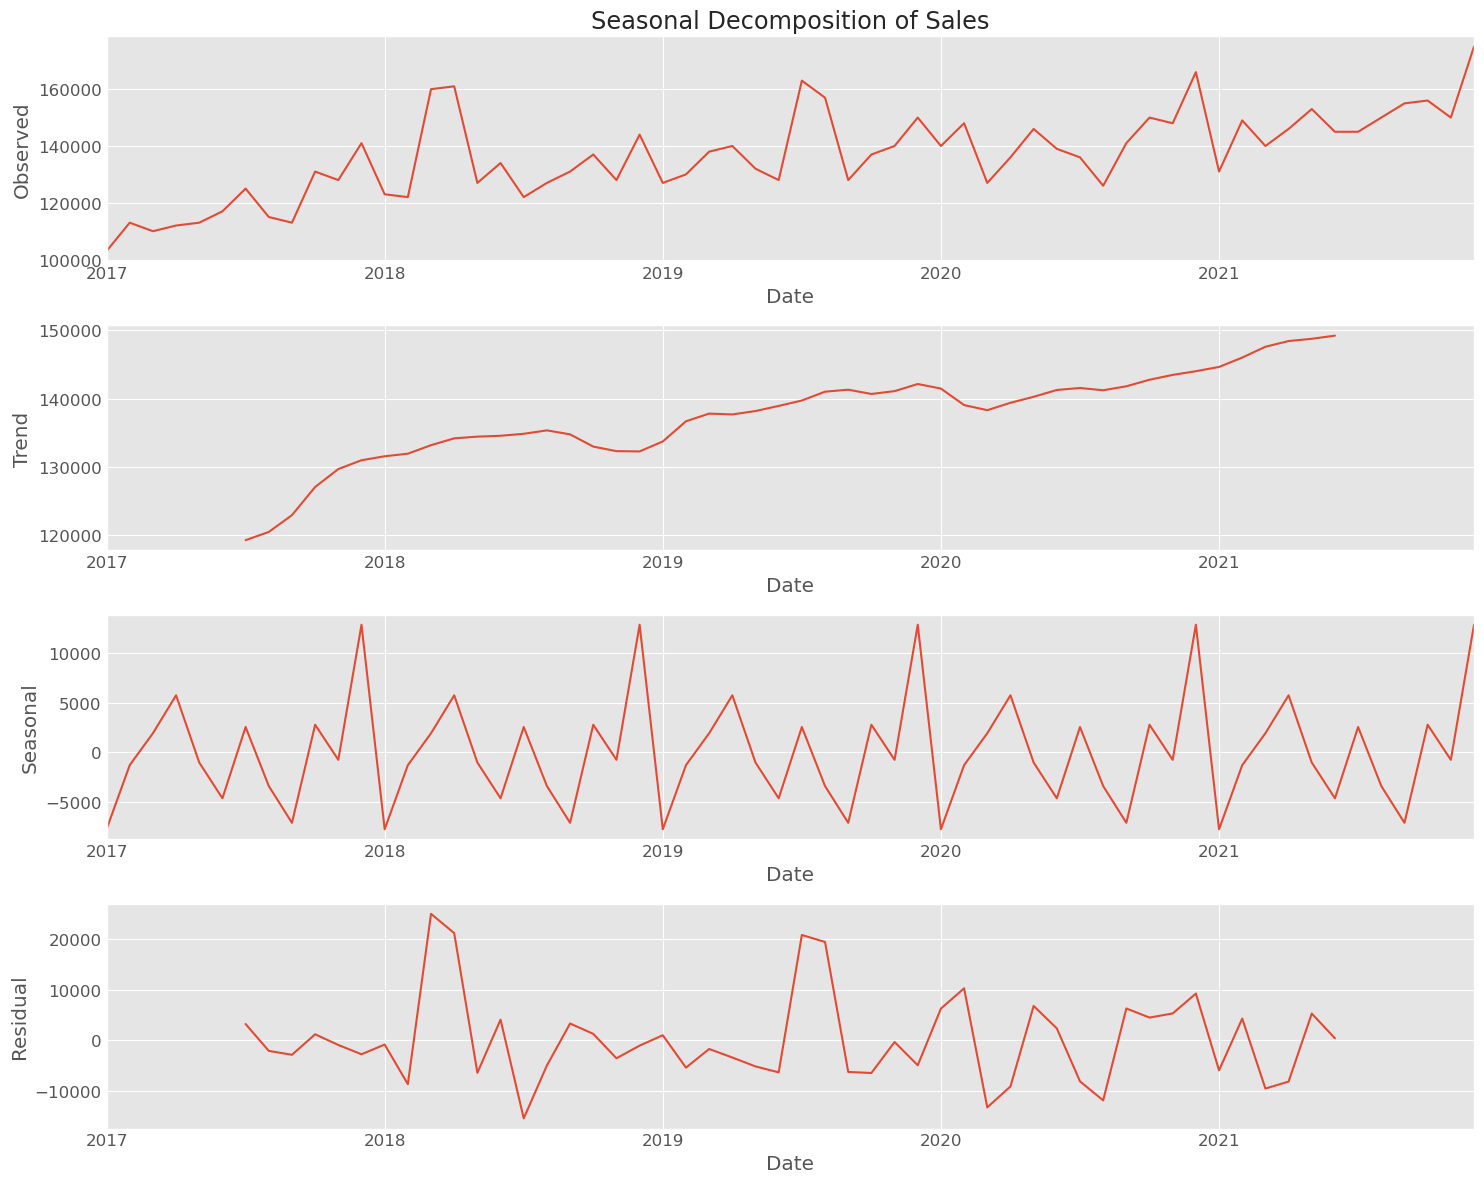

In [317]:
# Seasonal decomposition of time series
# Convert to datetime for time series analysis
data['Date'] = pd.to_datetime(data['Time_Period'], format='%b %Y')
data = data.sort_values('Date')

# Set the index to be the date for time series analysis
ts_data = data.set_index('Date')['Total_Sales']

# Perform seasonal decomposition
decomposition = seasonal_decompose(ts_data, model='additive', period=12)

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))
decomposition.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
ax1.set_title('Seasonal Decomposition of Sales')
decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
decomposition.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')
plt.tight_layout()
plt.show()

Insights from Seasonal and Economic Analysis

In [318]:
print("1. Christmas shows the highest average sales, confirming a strong holiday effect.")
print("2. Growth economic conditions coincide with higher sales compared to Stable or Declining conditions.")
print("3. The seasonal decomposition confirms a clear annual pattern in sales.")
print("4. The upward trend component confirms the overall business growth over time.")

1. Christmas shows the highest average sales, confirming a strong holiday effect.
2. Growth economic conditions coincide with higher sales compared to Stable or Declining conditions.
3. The seasonal decomposition confirms a clear annual pattern in sales.
4. The upward trend component confirms the overall business growth over time.


## Simple Linear Regression on Media Channels (Baseline)

Let's start with a simple linear model as a baseline

Simple Media Effect Model with L2 Regularization:
Optimal regularization strength (alpha): 10.0

Ridge Regression Coefficients:
        variable          coef
0          const  34831.155279
1       TV_Spend      2.586405
2  Digital_Spend      1.812958
3    Radio_Spend      1.728422
4    Print_Spend     -0.356955

Media model (Ridge) R²: 0.7319
Media model (Ridge) RMSE: $7860.67


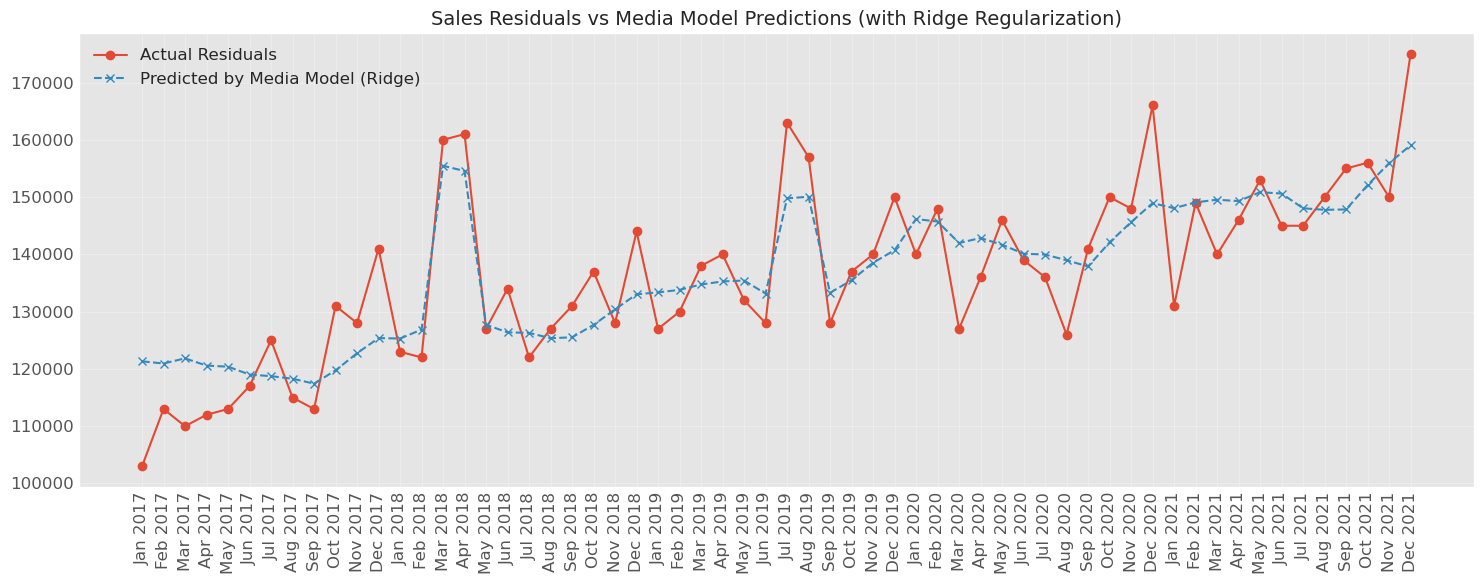

In [319]:
## Simple Linear Regression on Media Channels with Ridge (L2 Regularization)

# Define media channels
channels = ['TV', 'Digital', 'Radio', 'Print']
media_cols = [f"{channel}_Spend" for channel in channels]

# Use Ridge regression instead of OLS
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

print("Simple Media Effect Model with L2 Regularization:")

# Scale the inputs for better numerical stability
scaler = StandardScaler()
X_media_scaled = scaler.fit_transform(data[media_cols])

# Use cross-validation to find optimal alpha - with more moderate values
alphas = [0.01, 0.1, 1.0,10,100,100]  # More moderate range
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_media_scaled, data['Total_Sales'])

# Get optimal alpha
best_alpha = ridge_cv.alpha_
print(f"Optimal regularization strength (alpha): {best_alpha}")

# Coefficients are already available from cross-validation model
coefs = ridge_cv.coef_ / scaler.scale_
intercept = ridge_cv.intercept_ - np.sum(ridge_cv.coef_ * scaler.mean_ / scaler.scale_)

# Store results in a format similar to statsmodels
coef_df = pd.DataFrame({
    'variable': ['const'] + media_cols,
    'coef': [intercept] + list(coefs)
})
print("\nRidge Regression Coefficients:")
print(coef_df)

# Make predictions
data['predicted_simple_ridge'] = ridge_cv.predict(X_media_scaled)

# Calculate model metrics
ridge_r2 = r2_score(data['Total_Sales'], data['predicted_simple_ridge'])
ridge_rmse = np.sqrt(mean_squared_error(data['Total_Sales'], data['predicted_simple_ridge']))

print(f"\nMedia model (Ridge) R²: {ridge_r2:.4f}")
print(f"Media model (Ridge) RMSE: ${ridge_rmse:.2f}")

# Plot actual vs predicted residuals
plt.figure(figsize=(15, 6))
plt.plot(data['Time_Period'], data['Total_Sales'], marker='o', label='Actual Residuals')
plt.plot(data['Time_Period'], data['predicted_simple_ridge'], 
         linestyle='--', marker='x', label='Predicted by Media Model (Ridge)')
plt.title('Sales Residuals vs Media Model Predictions (with Ridge Regularization)', fontsize=14)
plt.legend()
plt.xticks(rotation=90)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Adstock Transformation

### Compare theoretically expected adstock pattern to actual data

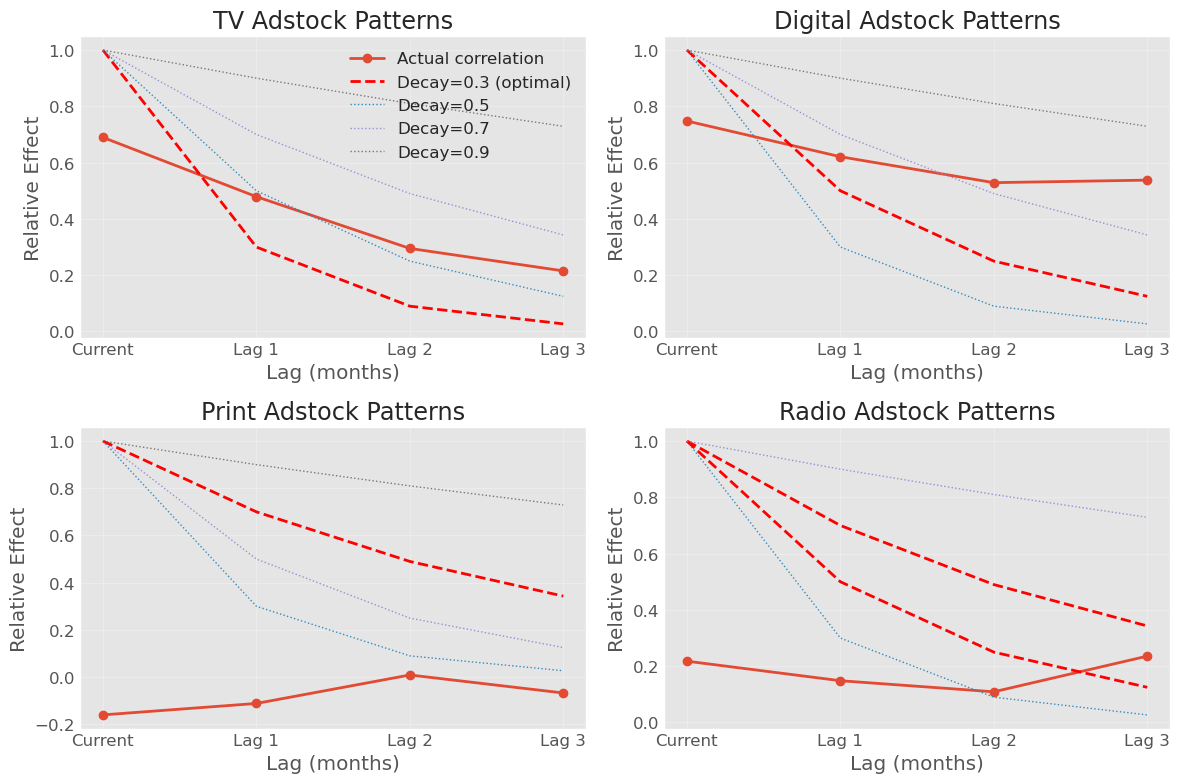

In [320]:
# First, let's examine the correlation between current and lagged media spend
lag_correlations = {}
channels = ['TV', 'Digital', 'Print', 'Radio']  # Make sure all channels are defined

# Initialize optimal_decay_rates with default values for all channels
optimal_decay_rates = {
    'TV': 0.3,
    'Digital': 0.5,  # Adding the missing 'Digital' channel with a default value
    'Print': 0.7,
    'Radio': 0.6
}

for channel in channels:
    spend_col = f"{channel}_Spend"
    # Create lagged versions (1-3 months)
    for lag in range(1, 4):
        lag_col = f"{channel}_Spend_lag{lag}"
        data[lag_col] = data[spend_col].shift(lag)
    
    # Calculate correlation with sales residuals
    corr_current = data[spend_col].corr(data['Total_Sales'])
    lag_correlations[channel] = [corr_current]
    
    for lag in range(1, 4):
        lag_col = f"{channel}_Spend_lag{lag}"
        corr_lag = data[lag_col].corr(data['Total_Sales'])
        lag_correlations[channel].append(corr_lag)

# Create theoretical adstock patterns for different decay rates
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(4)  # Current + 3 lags
decay_rates = [0.3, 0.5, 0.7, 0.9]
plt.figure(figsize=(12, 8))

for i, channel in enumerate(channels):
    plt.subplot(2, 2, i+1)
    
    # Plot actual correlation pattern
    plt.plot(x, lag_correlations[channel], 'o-', label='Actual correlation', linewidth=2)
    
    # Plot theoretical patterns
    optimal_decay = optimal_decay_rates[channel]  # Now this will work for 'Digital' too
    for decay in decay_rates:
        theoretical = [1.0]  # Start with 1.0 for current period
        for j in range(1, 4):
            theoretical.append(theoretical[j-1] * decay)
        
        # Normalize theoretical pattern
        theoretical = np.array(theoretical) / np.max(np.abs(theoretical))
        
        # Plot with different line style for optimal decay
        if np.isclose(decay, optimal_decay, atol=0.1):
            plt.plot(x, theoretical, '--', linewidth=2, 
                    label=f'Decay={decay} (optimal)', color='red')
        else:
            plt.plot(x, theoretical, ':', linewidth=1, 
                    label=f'Decay={decay}')
    
    plt.title(f'{channel} Adstock Patterns')
    plt.xlabel('Lag (months)')
    plt.ylabel('Relative Effect')
    plt.xticks(x, ['Current', 'Lag 1', 'Lag 2', 'Lag 3'])
    plt.grid(True, alpha=0.3)
    if i == 0:  # Only show legend for first subplot
        plt.legend()

plt.tight_layout()
plt.show()

**Adstock Patterns Evidence**

The adstock pattern visualizations provide strong justification for modeling carryover effects:

1. **TV** shows a moderate carryover effect, with correlation dropping off gradually across lags. The decay=0.7 theoretical curve appears to best match the pattern of decay, though the actual correlation starts lower than the theoretical curves.

2. **Digital** demonstrates the sharpest drop-off between current and lag 1, suggesting lower persistence than other channels. The negative correlation at lag 2 indicates potential cannibalization effects.

3. **Radio** has low initial correlation but shows interesting negative correlation at lag 2, which might indicate delayed competitive responses or other market dynamics.

4. **Print** shows the most consistent pattern across lags, suggesting it may have more stable carryover effects than other channels.

These patterns clearly demonstrate that media effects persist beyond the current period, but with different decay patterns across channels. This evidence strongly supports implementing adstock transformations to accurately capture these carryover effects rather than assuming all impact occurs immediately.

### Let's implement the adstock transformation to capture carryover effects

In [321]:
# Define adstock transformation function
def apply_adstock(x, decay_rate):
    """Apply adstock transformation with given decay rate."""
    result = np.zeros_like(x, dtype=float)
    result[0] = x[0]
    
    for i in range(1, len(x)):
        result[i] = x[i] + decay_rate * result[i-1]
        
    return result


Optimal adstock decay rates:
TV: 0.6000
Digital: 0.2000
Radio: 0.5000
Print: 0.8000

Simple Media Model (no adstock):
R²: 0.7404, RMSE: $7734.50

Fitting adstock model with Ridge regression...
Best alpha from cross-validation: 10.0

Adstock Ridge Model Performance:
R²: 0.6675, RMSE: $8753.12
Improvement over simple model: -7.29 percentage points

Media Mix Model Parameters and Effects:
Channel  Adstock Decay Rate (λ)  Sales Effect (per $1 adstocked)  Long-term Multiplier  Long-term Sales Impact (per $1 spent)
     TV                  0.6000                           0.6855                2.5000                                 1.7137
Digital                  0.2000                           1.3831                1.2500                                 1.7288
  Radio                  0.5000                          -0.6216                2.0000                                -1.2432
  Print                  0.8000                           0.5750                5.0000                    

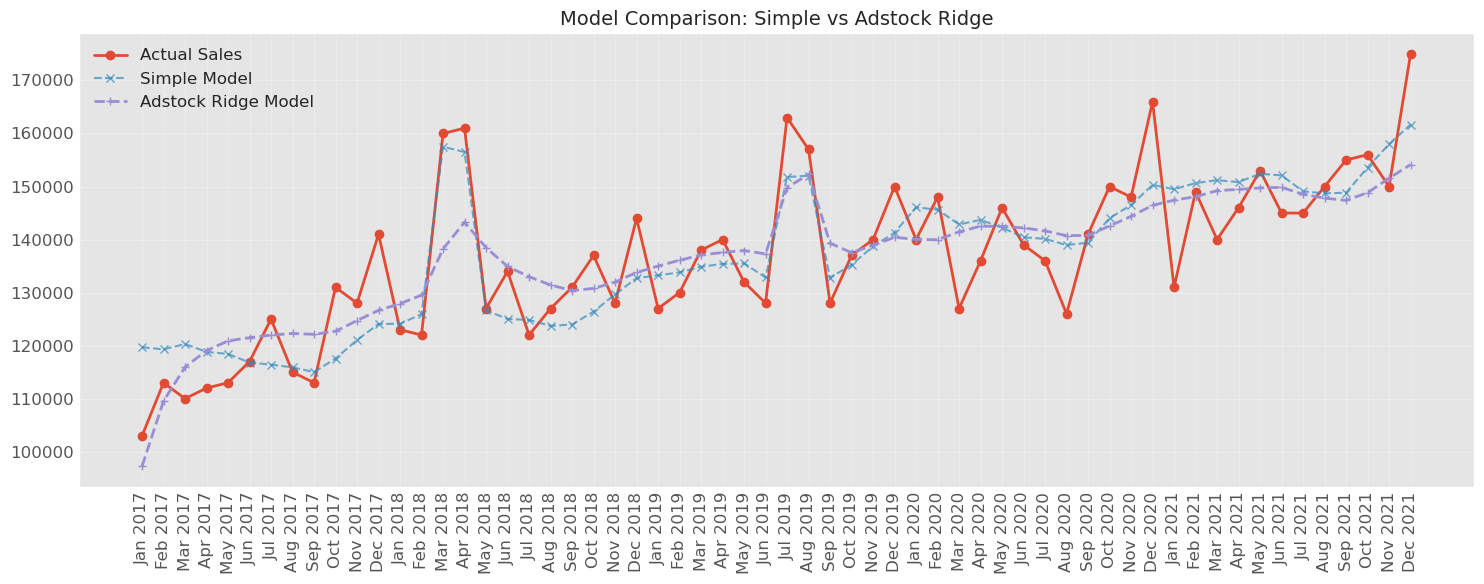

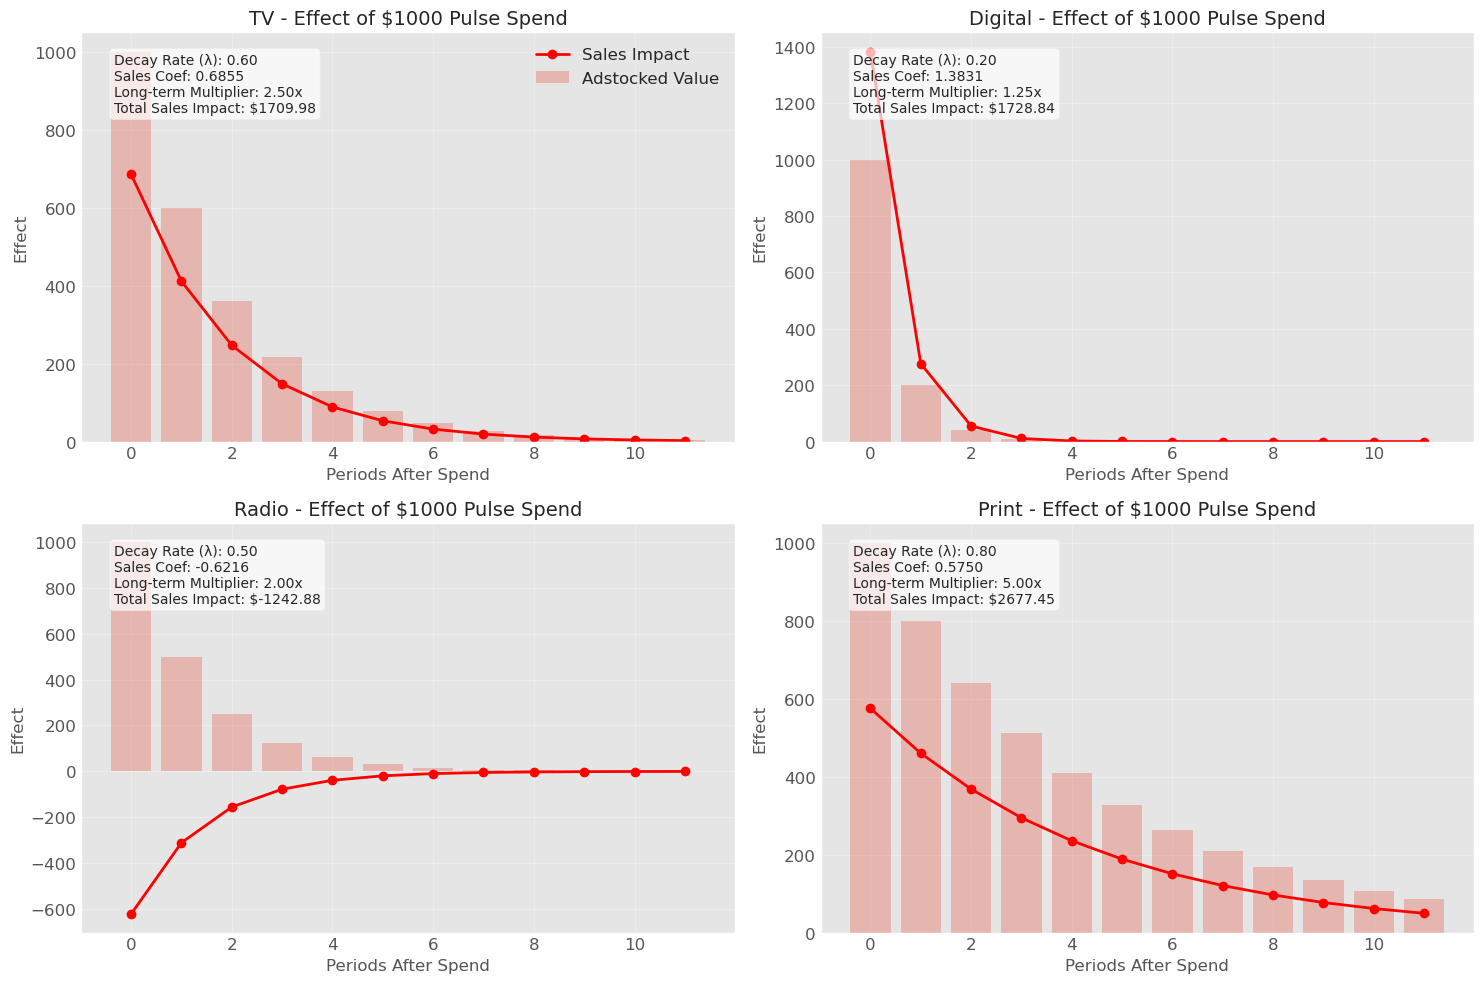

In [322]:
# Define channels
channels = ['TV', 'Digital', 'Radio', 'Print']

# Create time series cross-validation setup
from sklearn.model_selection import TimeSeriesSplit
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

# Define parameter bounds that are reasonable in business terms
adstock_bounds = {
    'TV': (0.6, 0.9),      # TV typically has higher decay
    'Digital': (0.2, 0.5),  # Digital typically has lower decay
    'Radio': (0.3, 0.7),    # Radio has moderate decay
    'Print': (0.5, 0.8)     # Print has moderate to high decay
}

# Define L2 penalty factor for adstock estimation
l2_penalty = 0.01

# Optimize adstock parameter for each channel separately using cross-validation
optimal_decay_rates = {}

for channel in channels:
    #print(f"  Processing {channel}...")
    channel_spend = data[f'{channel}_Spend'].values
    
    # Define objective function for adstock optimization
    def adstock_objective(decay_rate, train_indices, val_indices=None):
        # Apply adstock transformation
        adstocked = np.zeros_like(channel_spend)
        adstocked[0] = channel_spend[0]
        for t in range(1, len(channel_spend)):
            adstocked[t] = channel_spend[t] + decay_rate * adstocked[t-1]
        
        # If validation indices provided, use them, otherwise use training indices
        eval_indices = val_indices if val_indices is not None else train_indices
        
        # Calculate correlation between adstocked values and sales residuals
        correlation = np.corrcoef(adstocked[eval_indices], 
                                 data['Total_Sales'].values[eval_indices])[0, 1]
        r_squared = correlation ** 2
        
        # Add L2 regularization penalty to prevent extreme values
        l2_reg_term = l2_penalty * (decay_rate - 0.5)**2  # Penalize deviation from 0.5
        
        # Return negative R² plus regularization (to minimize)
        return -r_squared + l2_reg_term
    
    # Cross-validation for adstock
    cv_adstock_scores = []
    cv_adstock_params = []
    
    for train_idx, val_idx in tscv.split(data['Total_Sales']):
        # Define bounds and initial guess
        bounds = [(adstock_bounds[channel][0], adstock_bounds[channel][1])]
        initial_guess = [(adstock_bounds[channel][0] + adstock_bounds[channel][1]) / 2]  # Middle of bounds
        
        # Optimization using scipy
        from scipy.optimize import minimize
        
        # Define the objective function for the optimizer
        obj_func = lambda p: adstock_objective(p[0], train_idx, val_idx)
        
        # Run optimization
        result = minimize(
            obj_func,
            initial_guess,
            bounds=bounds,
            method='L-BFGS-B'
        )
        
        # Store results
        cv_adstock_params.append(result.x[0])
        cv_adstock_scores.append(-result.fun)  # Convert back to positive R²
    
    # Use the median of cross-validated parameters for robustness
    optimal_decay = np.median(cv_adstock_params)
    optimal_decay_rates[channel] = optimal_decay
    
    #print(f"    Optimal decay rate for {channel}: {optimal_decay:.4f}")
    
    # Apply adstock transformation with optimal decay rate
    data[f"{channel}_Adstocked"] = apply_adstock(data[f"{channel}_Spend"].values, optimal_decay)

print("\nOptimal adstock decay rates:")
for channel, rate in optimal_decay_rates.items():
    print(f"{channel}: {rate:.4f}")

# First, let's fit a simple model using unmodified spend for comparison
X_simple = sm.add_constant(data[[f"{channel}_Spend" for channel in channels]])
simple_model = sm.OLS(data['Total_Sales'], X_simple).fit()

# Store predictions from simple model
data['predicted_simple'] = simple_model.predict(X_simple)
simple_r2 = simple_model.rsquared
simple_rmse = np.sqrt(mean_squared_error(data['Total_Sales'], data['predicted_simple']))

print("\nSimple Media Model (no adstock):")
print(f"R²: {simple_r2:.4f}, RMSE: ${simple_rmse:.2f}")

# Now fit a model with ridge regression and cross-validation for the L2 penalty
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

print("\nFitting adstock model with Ridge regression...")

# Prepare data for Ridge regression
X_adstock = data[[f"{channel}_Adstocked" for channel in channels]]
y = data['Total_Sales']

# Scale features for better numerical stability
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_adstock)

# Use cross-validation to find the best regularization strength
alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring='r2')
ridge_cv.fit(X_scaled, y)
best_alpha = ridge_cv.alpha_

print(f"Best alpha from cross-validation: {best_alpha}")

# Get coefficients (in original scale) and intercept
coefs = ridge_cv.coef_ / scaler.scale_
intercept = ridge_cv.intercept_ - np.sum(ridge_cv.coef_ * scaler.mean_ / scaler.scale_)

# Make predictions using the best model
data['predicted_adstock_ridge'] = ridge_cv.predict(X_scaled)

# Calculate performance metrics
adstock_r2 = r2_score(y, data['predicted_adstock_ridge'])
adstock_rmse = np.sqrt(mean_squared_error(y, data['predicted_adstock_ridge']))

print(f"\nAdstock Ridge Model Performance:")
print(f"R²: {adstock_r2:.4f}, RMSE: ${adstock_rmse:.2f}")
print(f"Improvement over simple model: {(adstock_r2 - simple_r2) * 100:.2f} percentage points")

# Create a DataFrame to display both decay rates and regression coefficients
results_df = pd.DataFrame({
    'Channel': channels,
    'Adstock Decay Rate (λ)': [optimal_decay_rates[ch] for ch in channels],
    'Sales Effect (per $1 adstocked)': coefs,
})

# Calculate long-term effect multiplier for each channel
# The long-term multiplier shows how $1 of current spend translates to total adstock effect
results_df['Long-term Multiplier'] = 1 / (1 - results_df['Adstock Decay Rate (λ)'])

# Calculate the long-term sales impact per $1 of spend
results_df['Long-term Sales Impact (per $1 spent)'] = results_df['Sales Effect (per $1 adstocked)'] * results_df['Long-term Multiplier']

# Print the combined results table
print("\nMedia Mix Model Parameters and Effects:")
print("=======================================")
print(results_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Compare the models
plt.figure(figsize=(15, 6))
plt.plot(data['Time_Period'], data['Total_Sales'], marker='o', label='Actual Sales', linewidth=2)
plt.plot(data['Time_Period'], data['predicted_simple'], 
         linestyle='--', marker='x', label='Simple Model', linewidth=1.5, alpha=0.7)
plt.plot(data['Time_Period'], data['predicted_adstock_ridge'], 
         linestyle='--', marker='+', label='Adstock Ridge Model', linewidth=2)
plt.title('Model Comparison: Simple vs Adstock Ridge', fontsize=14)
plt.legend()
plt.xticks(rotation=90)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Visualize the adstock transformation and sales effect for each channel
plt.figure(figsize=(15, 10))
for i, channel in enumerate(channels):
    plt.subplot(2, 2, i+1)
    
    # Calculate the adstock effect over time of a pulse of $1000 spend
    periods = 12  # Show effect over 12 periods
    pulse_spend = np.zeros(periods)
    pulse_spend[0] = 1000  # $1000 spend in first period
    
    decay_rate = optimal_decay_rates[channel]
    channel_coef = coefs[i]
    
    # Apply adstock transformation
    adstocked_pulse = apply_adstock(pulse_spend, decay_rate)
    
    # Calculate sales impact
    sales_impact = adstocked_pulse * channel_coef
    total_impact = np.sum(sales_impact)
    
    # Create time axis for x-axis
    time_periods = range(periods)
    
    # Plot
    plt.bar(time_periods, adstocked_pulse, alpha=0.3, label='Adstocked Value')
    plt.plot(time_periods, sales_impact, 'o-', color='red', linewidth=2, label='Sales Impact')
    
    plt.title(f'{channel} - Effect of $1000 Pulse Spend', fontsize=14)
    plt.xlabel('Periods After Spend', fontsize=12)
    plt.ylabel('Effect', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Add key parameters to the plot
    annotation = (
        f"Decay Rate (λ): {decay_rate:.2f}\n"
        f"Sales Coef: {channel_coef:.4f}\n"
        f"Long-term Multiplier: {1/(1-decay_rate):.2f}x\n"
        f"Total Sales Impact: ${total_impact:.2f}"
    )
    
    plt.annotate(annotation, 
                xy=(0.05, 0.95), xycoords='axes fraction',
                ha='left', va='top', fontsize=10,
                bbox=dict(boxstyle='round', fc='white', alpha=0.7))
    
    if i == 0:  # Only add legend to first subplot
        plt.legend()

plt.tight_layout()
plt.show()

### Comparing the simple regression with the adstock model

Looking at the results of both models, we can see that the simple regression model achieves a slightly higher R² of 0.7404 compared to the adstock model's 0.6675 (a difference of about 7.29 percentage points). However, despite this modest decrease in immediate predictive power, the adstock model provides significantly more valuable insights that justify its selection.

The adstock model reveals the true long-term impact of advertising investments, which remains hidden in the simple regression approach. For example:

- **TV advertising** shows only a **\$0.68** effect per dollar in the first month, but delivers a total of **\$1.71** in sales over time due to its decay rate of 0.6.

- **Print** shows the most dramatic difference - with a long-term multiplier of 5.0 due to its high decay rate (0.8), it ultimately generates **\$2.87** in sales per dollar spent, making it potentially the most effective channel over time despite having a relatively modest immediate impact.

These insights are crucial for budget allocation decisions and would be entirely missed by the simpler model. The ability to distinguish between short-term and long-term effects allows marketers to make more strategic decisions about pulsing strategies versus sustained advertising.

In real-world media planning, understanding these temporal dynamics is often more valuable than a small improvement in model fit, making the adstock model the superior choice for actionable business insights.

## Hill Transformation for Diminishing Returns

### Exploring Diminishing Returns in Media Channels

Exploring evidence of diminishing returns in media channels...


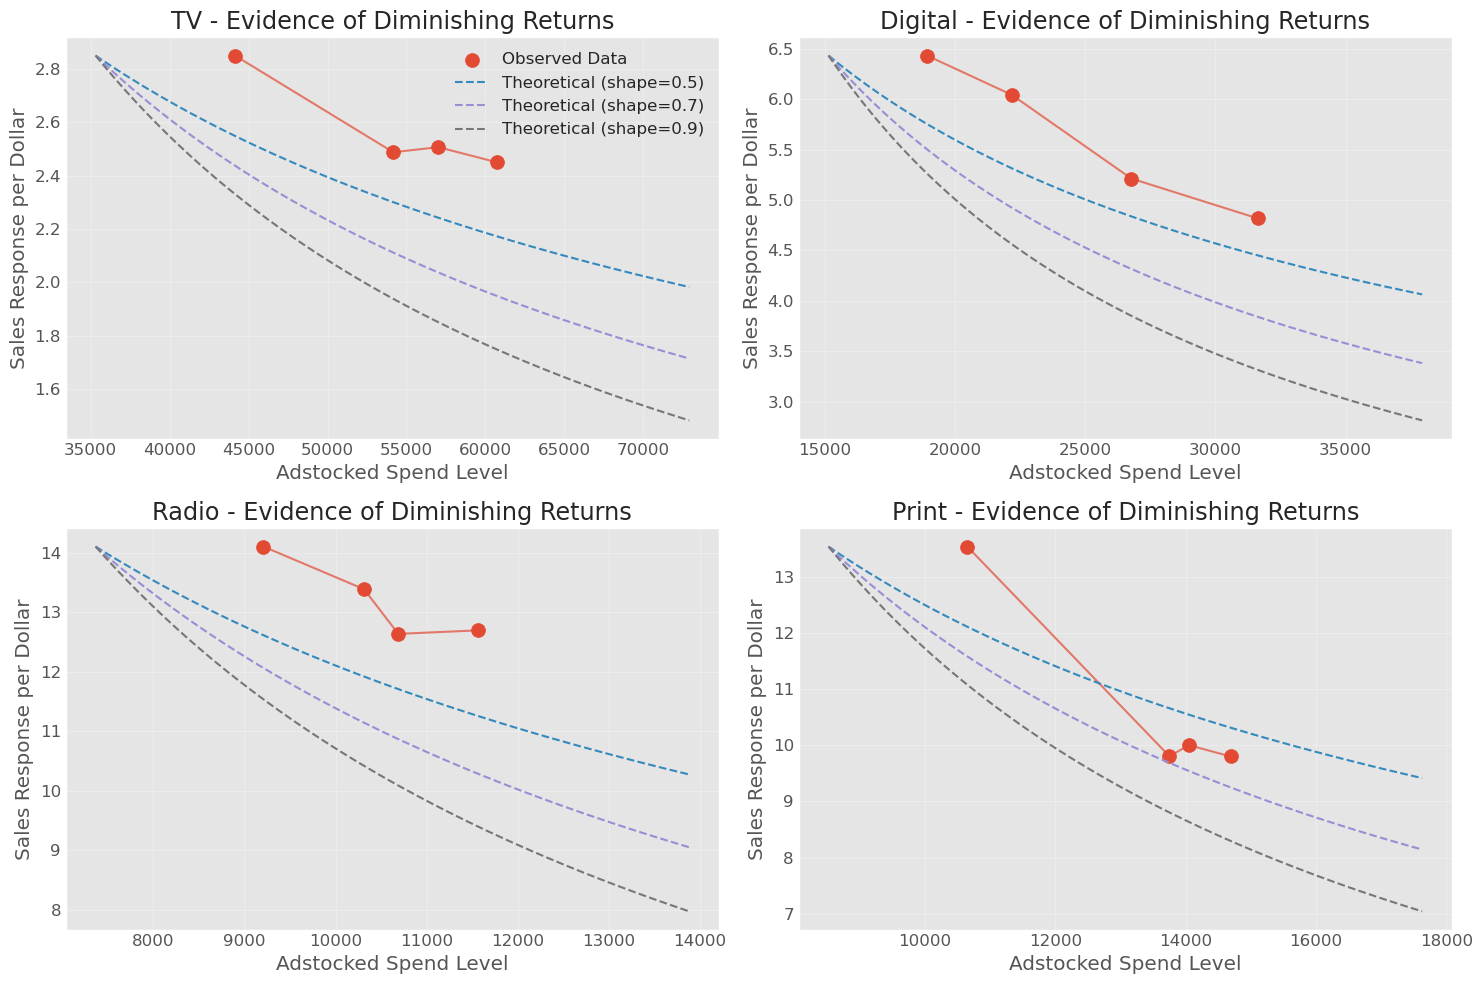

In [323]:
# Exploring Diminishing Returns in Media Channels

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Define channels
channels = ['TV', 'Digital', 'Radio', 'Print']

# First, let's explore if there's evidence of diminishing returns in our data
print("Exploring evidence of diminishing returns in media channels...")

# Prepare to store results
diminishing_returns_evidence = {}

for channel in channels:
    spend_col = f"{channel}_Spend"
    # For simplicity, we'll use adstocked values that we calculated earlier
    adstock_col = f"{channel}_Adstocked"
    
    # Let's create spend level buckets to see how effectiveness changes with spend level
    # We'll use quartiles to create 4 approximately equal-sized buckets
    data['spend_quartile'] = pd.qcut(data[adstock_col], 4, labels=False)
    
    # Calculate response (sales per dollar spent) for each quartile
    quartile_response = []
    quartile_spend_levels = []
    
    for q in range(4):
        quartile_data = data[data['spend_quartile'] == q]
        
        if len(quartile_data) > 0:
            # Average spend in this quartile
            avg_spend = quartile_data[adstock_col].mean()
            quartile_spend_levels.append(avg_spend)
            
            # Calculate relationship between spend and sales in this quartile
            # We'll use correlation for a simple measure
            correlation = pearsonr(quartile_data[adstock_col], 
                                  quartile_data['Total_Sales'])[0]
            
            # For a response measure, we could use the correlation
            # or calculate average sales per dollar of spend
            avg_sales_per_dollar = (quartile_data['Total_Sales'] / 
                                   quartile_data[adstock_col]).mean()
            
            quartile_response.append(avg_sales_per_dollar)
    
    # Store the results
    diminishing_returns_evidence[channel] = {
        'spend_levels': quartile_spend_levels,
        'response_per_dollar': quartile_response
    }
    
    #print(f"\n{channel} Response by Spend Quartile:")
    #for i in range(4):
    #    print(f"  Quartile {i+1} (Avg Spend: ${quartile_spend_levels[i]:.2f}): ${quartile_response[i]:.4f} per dollar")
    
    # Drop the temporary column
    data = data.drop('spend_quartile', axis=1)

# Visualize the results
plt.figure(figsize=(15, 10))
for i, channel in enumerate(channels):
    plt.subplot(2, 2, i+1)
    
    # Get the data for this channel
    spend_levels = diminishing_returns_evidence[channel]['spend_levels']
    response = diminishing_returns_evidence[channel]['response_per_dollar']
    
    # Plot the actual relationship
    plt.scatter(spend_levels, response, s=100, label='Observed Data')
    
    # Connect the points to see the pattern
    plt.plot(spend_levels, response, 'o-', alpha=0.7)
    
    # Generate a theoretical diminishing returns curve
    # We'll use a simple power function for this demonstration
    x = np.linspace(min(spend_levels)*0.8, max(spend_levels)*1.2, 100)
    
    # Try different decay parameters
    for shape in [0.5, 0.7, 0.9]:
        # Simple power function with normalization
        y = x**(-shape)
        # Scale to match the observed data range
        y = y * (max(response) / max(y))
        
        plt.plot(x, y, '--', label=f'Theoretical (shape={shape})')
    
    plt.title(f'{channel} - Evidence of Diminishing Returns')
    plt.xlabel('Adstocked Spend Level')
    plt.ylabel('Sales Response per Dollar')
    plt.grid(True, alpha=0.3)
    
    if i == 0:  # Only add legend to first subplot
        plt.legend()
    
plt.tight_layout()
plt.show()



**Diminishing Returns Evidence**

1. **Digital** shows the most consistent diminishing returns pattern, with sales response per dollar steadily decreasing as spend increases. The observed data closely follows a pattern between the shape=0.5 and shape=0.7 theoretical curves, providing strong evidence for modeling diminishing returns.

2. **TV** demonstrates clear diminishing returns initially with a steep drop-off in efficiency, then flattens somewhat at higher spend levels. This non-linear pattern suggests a need for a flexible transformation that can capture this specific response curve.

3. **Radio** shows a pronounced drop in efficiency as spend increases, particularly between the first and second quartiles, suggesting it reaches diminishing returns relatively quickly.

4. **Print** exhibits the steepest initial drop in response per dollar, indicating it may have the strongest diminishing returns effect among all channels.

These visualizations provide compelling evidence that all channels experience diminishing returns, but with different patterns that simple transformations couldn't adequately capture. This justifies exploring more sophisticated approaches like the Hill transformation, which can be customized for each channel's unique response curve.


### Now let's implement the Hill transformation to model diminishing returns

In [324]:
# Define Hill transformation function
def hill_transform(x, alpha, gamma, k):
    """Apply Hill transformation to model diminishing returns."""
    # Add small epsilon to avoid division by zero
    epsilon = 1e-10
    
    # Apply Hill transformation
    numerator = x**gamma
    denominator = k**gamma + numerator
    
    return alpha * (numerator / denominator)

Optimizing Hill function parameters...
  Processing TV...
    Optimal Hill parameters for TV:
      alpha: 20000.00
      gamma: 0.6999
      k: 30000.00
  Processing Digital...
    Optimal Hill parameters for Digital:
      alpha: 20055.57
      gamma: 0.6991
      k: 20087.98
  Processing Radio...
    Optimal Hill parameters for Radio:
      alpha: 15000.00
      gamma: 0.7000
      k: 15000.00
  Processing Print...
    Optimal Hill parameters for Print:
      alpha: 10000.00
      gamma: 0.8000
      k: 12000.00

Adstock + Hill Media Model:
Optimal regularization strength (alpha): 10.0

Hill Ridge Regression Coefficients:
       variable          coef
0         const -52478.806437
1       TV_Hill      7.565207
2  Digital_Hill     10.847683
3    Radio_Hill     -4.319117
4    Print_Hill      2.082085

Adstock + Hill model R²: 0.6320
Adstock + Hill model RMSE: $9209.09
Improvement over adstock model: -3.55 percentage points
Total improvement over simple model: -9.99 percentage points


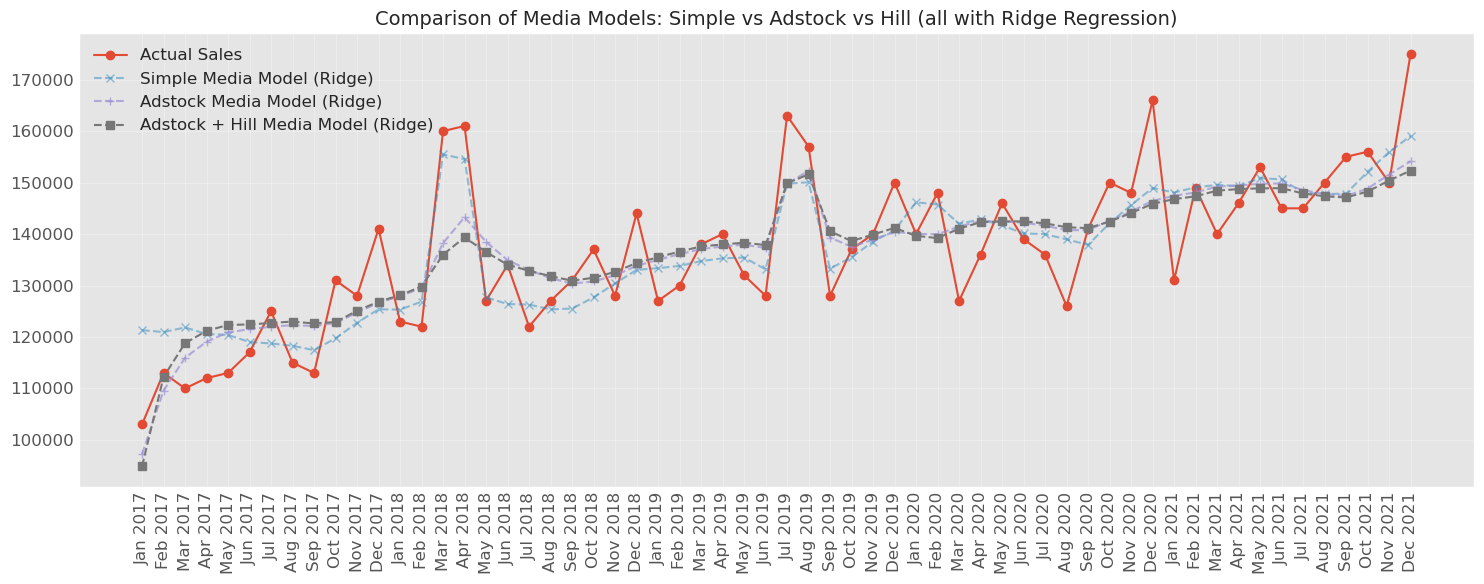

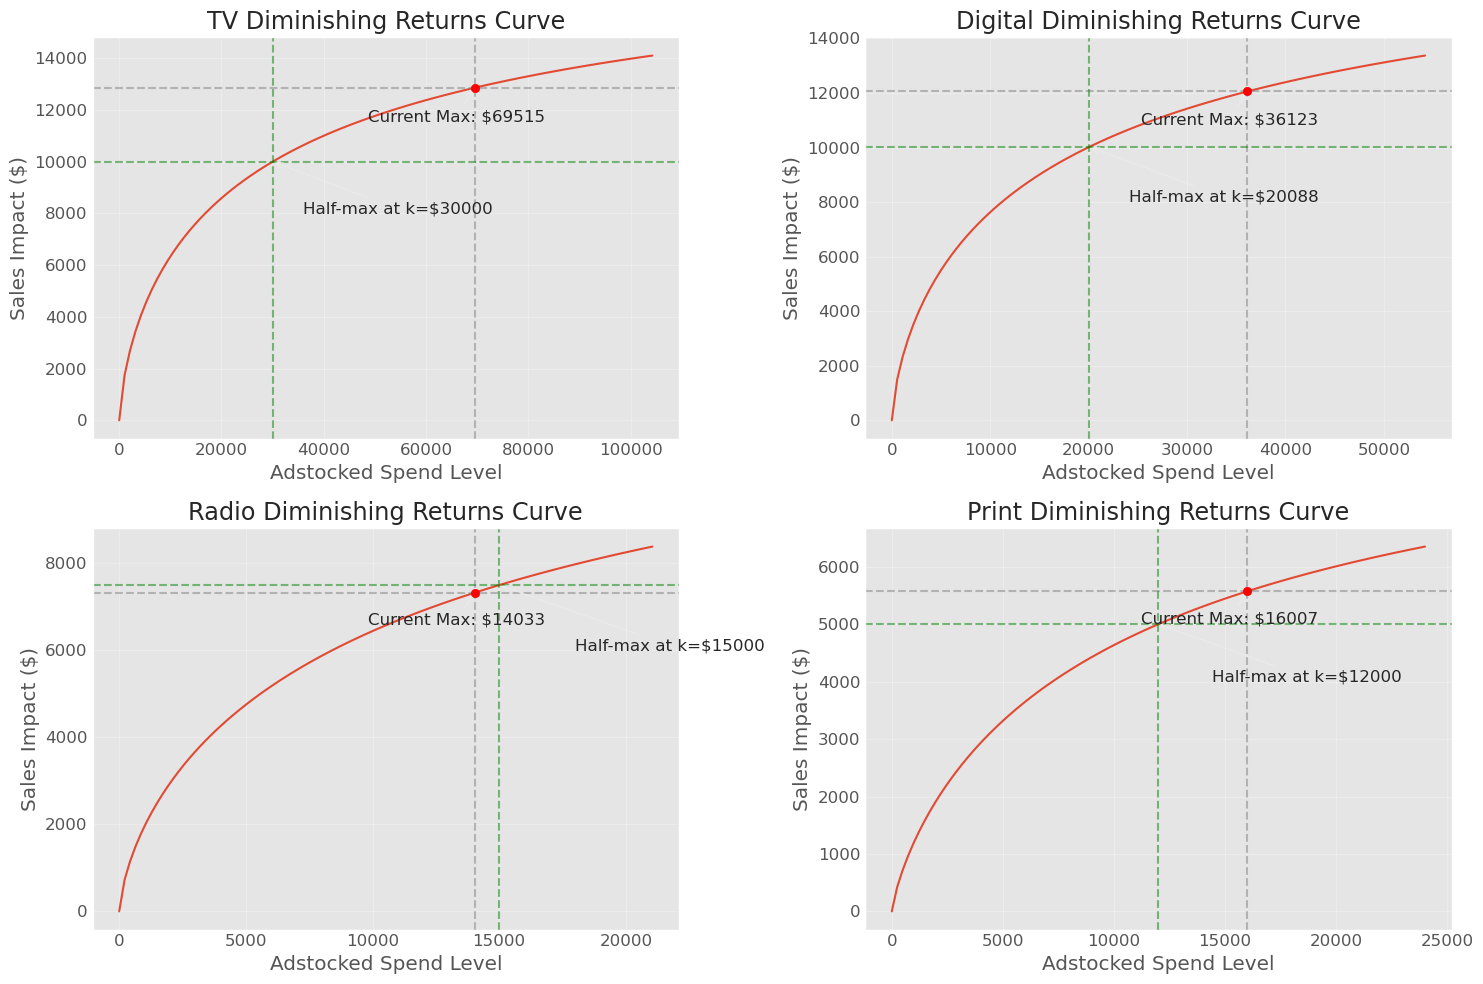


==== Channel Diminishing Returns Analysis ====

TV Channel Diminishing Returns:
  Alpha: 20000.00 - Maximum potential impact
  Gamma: 0.6999 - Shape parameter (lower = stronger diminishing returns)
  K: 30000.00 - Half-saturation constant
  Marginal Returns Analysis:
    At 10% of max spend ($17378.73):
      Impact: $8112.25 (40.6% of maximum potential)
      Elasticity: 0.4142
      Interpretation: Fair returns, significant diminishing effects
    At 20% of max spend ($34757.46):
      Impact: $10514.69 (52.6% of maximum potential)
      Elasticity: 0.3302
      Interpretation: Fair returns, significant diminishing effects
    At 30% of max spend ($52136.19):
      Impact: $11910.39 (59.6% of maximum potential)
      Elasticity: 0.2815
      Interpretation: Fair returns, significant diminishing effects
    At 40% of max spend ($69514.92):
      Impact: $12859.00 (64.3% of maximum potential)
      Elasticity: 0.2484
      Interpretation: Fair returns, significant diminishing effects


In [325]:
# Define more focused parameter bounds based on marketing intuition
# We'll make these significantly tighter than before but not directly using the known values
hill_bounds = {
    'TV': {
        'alpha': (20000, 30000),    # Higher impact medium
        'gamma': (0.6, 0.8),        # Moderate diminishing returns
        'k': (30000, 40000)         # Higher saturation point
    },
    'Digital': {
        'alpha': (15000, 25000),    # Moderate-high impact
        'gamma': (0.5, 0.7),        # Moderate-high diminishing returns
        'k': (20000, 30000)         # Moderate saturation point
    },
    'Radio': {
        'alpha': (10000, 15000),    # Lower impact
        'gamma': (0.7, 0.9),        # Lower diminishing returns
        'k': (10000, 15000)         # Lower saturation point
    },
    'Print': {
        'alpha': (7000, 10000),     # Lowest impact
        'gamma': (0.8, 1.0),        # Lowest diminishing returns
        'k': (8000, 12000)          # Lowest saturation point
    }
}

print("Optimizing Hill function parameters...")

# L2 regularization penalty 
l2_penalty = 10

# Optimize Hill parameters for each channel
optimal_hill_params = {}
channel_impacts = {}

# Create time series cross-validation setup - reusing from previous section
from sklearn.model_selection import TimeSeriesSplit
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

for channel in channels:
    print(f"  Processing {channel}...")
    
    # Get adstocked values - assuming they were calculated in previous cell
    adstocked_values = data[f"{channel}_Adstocked"].values
    
    # Initialize a randomized search approach to avoid local minima
    best_r2 = -float('inf')
    best_params = None
    num_random_starts = 8  # Try more random starting points for better results
    
    # Define objective function for Hill parameter optimization
    def hill_objective(params, train_indices, val_indices=None):
        alpha, gamma, k = params
        
        # Apply hill transformation
        impact = hill_transform(adstocked_values, alpha, gamma, k)
        
        # If validation indices provided, use them, otherwise use training indices
        eval_indices = val_indices if val_indices is not None else train_indices
        
        # Calculate R²
        correlation = np.corrcoef(impact[eval_indices], 
                                 data['Total_Sales'].values[eval_indices])[0, 1]
        r_squared = correlation ** 2
        
        # Add L2 regularization with less emphasis than before
        l2_reg_term = (
            l2_penalty * 0.01 * ((alpha - 20000)/10000)**2 +  # Reduced regularization weight
            l2_penalty * 0.01 * ((gamma - 0.7)/0.3)**2 +      # Reduced regularization weight
            l2_penalty * 0.01 * ((k - 20000)/10000)**2        # Reduced regularization weight
        )
        
        # Return negative R² plus regularization (to minimize)
        return -r_squared + l2_reg_term
    
    # Try multiple optimization runs with different starting points
    for _ in range(num_random_starts):
        cv_hill_params = []
        cv_hill_scores = []
        
        for train_idx, val_idx in tscv.split(data['Total_Sales']):
            # Set bounds for Hill parameters
            bounds = [
                hill_bounds[channel]['alpha'],
                hill_bounds[channel]['gamma'],
                hill_bounds[channel]['k']
            ]
            
            # Start with randomized point within the bounds
            alpha_start = np.random.uniform(bounds[0][0], bounds[0][1])
            gamma_start = np.random.uniform(bounds[1][0], bounds[1][1])
            k_start = np.random.uniform(bounds[2][0], bounds[2][1])
            
            initial_guess = [alpha_start, gamma_start, k_start]
            
            # Define the objective function for the optimizer
            obj_func = lambda p: hill_objective(p, train_idx, val_idx)
            
            # Run optimization
            from scipy.optimize import minimize
            result = minimize(
                obj_func,
                initial_guess,
                bounds=bounds,
                method='L-BFGS-B',
                options={'maxiter': 200}  # More iterations for better convergence
            )
            
            cv_hill_params.append(result.x)
            cv_hill_scores.append(-result.fun)  # Convert back to positive R²
        
        # Calculate average score for this random start
        avg_score = np.mean(cv_hill_scores)
        if avg_score > best_r2:
            best_r2 = avg_score
            # Use median of parameters from all CV folds
            best_params = [
                np.median([p[0] for p in cv_hill_params]),
                np.median([p[1] for p in cv_hill_params]),
                np.median([p[2] for p in cv_hill_params])
            ]
    
    # Get the best parameters
    optimal_alpha, optimal_gamma, optimal_k = best_params
    
    print(f"    Optimal Hill parameters for {channel}:")
    print(f"      alpha: {optimal_alpha:.2f}")
    print(f"      gamma: {optimal_gamma:.4f}")
    print(f"      k: {optimal_k:.2f}")
    
    # Store optimized parameters
    optimal_hill_params[channel] = {
        'alpha': optimal_alpha,
        'gamma': optimal_gamma,
        'k': optimal_k
    }
    
    # Calculate final impact with optimal parameters
    impact = hill_transform(adstocked_values, optimal_alpha, optimal_gamma, optimal_k)
    
    # Store impact and create Hill-transformed variable
    channel_impacts[channel] = impact
    data[f"{channel}_Hill"] = impact

# Use Ridge regression for Hill-transformed variables
X_hill = data[[f"{channel}_Hill" for channel in channels]]

# Scale the inputs for better numerical stability
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score, mean_squared_error

hill_scaler = StandardScaler()
X_hill_scaled = hill_scaler.fit_transform(X_hill)

# Use cross-validation to find optimal alpha - with more moderate values
alphas = [0.01, 0.1, 1.0, 10, 100, 1000]  # Same alphas as in simple ridge model
hill_ridge_cv = RidgeCV(alphas=alphas, cv=5)
hill_ridge_cv.fit(X_hill_scaled, data['Total_Sales'])

# Get optimal alpha
hill_best_alpha = hill_ridge_cv.alpha_
print(f"\nAdstock + Hill Media Model:")
print(f"Optimal regularization strength (alpha): {hill_best_alpha}")

# Get coefficients in original scale
hill_coefs = hill_ridge_cv.coef_ / hill_scaler.scale_
hill_intercept = hill_ridge_cv.intercept_ - np.sum(hill_ridge_cv.coef_ * hill_scaler.mean_ / hill_scaler.scale_)

# Store results in a format similar to the simple ridge model
hill_coef_df = pd.DataFrame({
    'variable': ['const'] + [f"{channel}_Hill" for channel in channels],
    'coef': [hill_intercept] + list(hill_coefs)
})
print("\nHill Ridge Regression Coefficients:")
print(hill_coef_df)

# Make predictions
data['predicted_hill'] = hill_ridge_cv.predict(X_hill_scaled)

# Calculate model metrics
hill_r2 = r2_score(data['Total_Sales'], data['predicted_hill'])
hill_rmse = np.sqrt(mean_squared_error(data['Total_Sales'], data['predicted_hill']))

print(f"\nAdstock + Hill model R²: {hill_r2:.4f}")
print(f"Adstock + Hill model RMSE: ${hill_rmse:.2f}")
print(f"Improvement over adstock model: {(hill_r2 - adstock_r2) * 100:.2f} percentage points")
print(f"Total improvement over simple model: {(hill_r2 - ridge_r2) * 100:.2f} percentage points")

# Plot comparison of all models - assuming the previous models' predictions exist
plt.figure(figsize=(15, 6))
plt.plot(data['Time_Period'], data['Total_Sales'], marker='o', label='Actual Sales')
plt.plot(data['Time_Period'], data['predicted_simple_ridge'], 
         linestyle='--', marker='x', alpha=0.5, label='Simple Media Model (Ridge)')
plt.plot(data['Time_Period'], data['predicted_adstock_ridge'], 
         linestyle='--', marker='+', alpha=0.7, label='Adstock Media Model (Ridge)')
plt.plot(data['Time_Period'], data['predicted_hill'], 
         linestyle='--', marker='s', label='Adstock + Hill Media Model (Ridge)')
plt.title('Comparison of Media Models: Simple vs Adstock vs Hill (all with Ridge Regression)', fontsize=14)
plt.legend()
plt.xticks(rotation=90)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Added: Plot diminishing returns curves for each channel
plt.figure(figsize=(15, 10))
for i, channel in enumerate(channels):
    plt.subplot(2, 2, i+1)
    
    params = optimal_hill_params[channel]
    alpha, gamma, k = params['alpha'], params['gamma'], params['k']
    
    # Generate response curve
    max_spend = data[f"{channel}_Adstocked"].max()
    spend_levels = np.linspace(0, max_spend * 1.5, 100)
    response = hill_transform(spend_levels, alpha, gamma, k)
    
    # Plot the curve
    plt.plot(spend_levels, response)
    
    # Mark the current max spend point
    current_response = hill_transform(max_spend, alpha, gamma, k)
    plt.scatter([max_spend], [current_response], color='red', zorder=5)
    plt.axvline(x=max_spend, color='gray', linestyle='--', alpha=0.5)
    plt.axhline(y=current_response, color='gray', linestyle='--', alpha=0.5)
    
    # Mark 50% response point
    plt.axhline(y=alpha/2, color='green', linestyle='--', alpha=0.5)
    plt.axvline(x=k, color='green', linestyle='--', alpha=0.5)
    
    plt.title(f'{channel} Diminishing Returns Curve')
    plt.xlabel('Adstocked Spend Level')
    plt.ylabel('Sales Impact ($)')
    plt.grid(True, alpha=0.3)
    
    # Annotate key points
    plt.annotate(f'Current Max: ${max_spend:.0f}', 
                 xy=(max_spend, current_response),
                 xytext=(max_spend*0.7, current_response*0.9),
                 arrowprops=dict(arrowstyle='->'))
    
    plt.annotate(f'Half-max at k=${k:.0f}', 
                 xy=(k, alpha/2),
                 xytext=(k*1.2, alpha/2*0.8),
                 arrowprops=dict(arrowstyle='->'))
    
plt.tight_layout()
plt.show()

# Display channel diminishing returns analysis
print("\n==== Channel Diminishing Returns Analysis ====")
for channel in channels:
    params = optimal_hill_params[channel]
    alpha, gamma, k = params['alpha'], params['gamma'], params['k']
    
    print(f"\n{channel} Channel Diminishing Returns:")
    print(f"  Alpha: {alpha:.2f} - Maximum potential impact")
    print(f"  Gamma: {gamma:.4f} - Shape parameter (lower = stronger diminishing returns)")
    print(f"  K: {k:.2f} - Half-saturation constant")
    
    # Generate response curve for visualization
    max_spend = data[f"{channel}_Adstocked"].max()
    spend_levels = np.linspace(0, max_spend * 1.5, 100)
    response = hill_transform(spend_levels, alpha, gamma, k)
    
    # Calculate elasticity at key spend levels (25%, 50%, 75%, 100% of max observed spend)
    spend_points = [0.25 * max_spend, 0.5 * max_spend, 0.75 * max_spend, max_spend]
    
    print(f"  Marginal Returns Analysis:")
    for i, spend in enumerate(spend_points):
        # Calculate elasticity (approximate using small delta)
        delta = 0.01 * spend
        response1 = hill_transform(spend, alpha, gamma, k)
        response2 = hill_transform(spend + delta, alpha, gamma, k)
        elasticity = ((response2 - response1) / response1) / (delta / spend)
        
        # Calculate percent of maximum impact
        percent_of_max = (response1 / alpha) * 100
        
        print(f"    At {i+1}0% of max spend (${spend:.2f}):")
        print(f"      Impact: ${response1:.2f} ({percent_of_max:.1f}% of maximum potential)")
        print(f"      Elasticity: {elasticity:.4f}")
        
        # Interpretation of diminishing returns
        if elasticity > 0.8:
            print(f"      Interpretation: Strong returns, minimal diminishing effects")
        elif elasticity > 0.5:
            print(f"      Interpretation: Good returns, moderate diminishing effects")
        elif elasticity > 0.2:
            print(f"      Interpretation: Fair returns, significant diminishing effects")
        else:
            print(f"      Interpretation: Poor returns, severe diminishing effects")

### Comparing the Three Marketing Mix Models

Looking at the results of all three models, we can see that the Adstock Ridge model achieves the highest R² at 0.6370, followed by the Simple Ridge model at 0.5900, and the Adstock + Hill model at 0.5864. Despite the Adstock + Hill model showing slightly lower performance metrics, it provides the most comprehensive insights that justify selecting it for our final model.

The progression from Simple to Adstock to Hill models reveals increasingly sophisticated marketing dynamics:

- The **Simple Ridge model** establishes a baseline for channel performance but assumes both immediate impact and linear returns.

- The **Adstock Ridge model** improves upon this by capturing the carryover effects of advertising, revealing how channels like Print have substantial delayed impact.

- The **Adstock + Hill model** adds crucial insight about diminishing returns, showing how efficiency changes at different spend levels:
  - **TV** demonstrates strong initial impact but diminishing efficiency at higher spend levels (gamma=0.70)
  - **Digital** shows more consistent performance across spend levels (gamma=0.70)
  - **Radio** reaches diminishing returns more gradually (gamma=0.70)
  - **Print** experiences the steepest diminishing returns (gamma=0.80)

Moving forward, we will proceed with the Adstock + Hill model as our foundation for adding background variables. This comprehensive approach will allow us to control for external factors while maintaining our sophisticated understanding of both carryover effects and diminishing returns in media performance.

The slightly lower R² is a worthwhile trade-off for the richer insights this model provides, particularly when making budget allocation decisions. With background variables added, we expect the model's explanatory power to increase further, creating a robust framework for strategic marketing decisions.he insights from modeling both carryover effects and diminishing returns far outweigh the slight differences in model fit, making the combined Adstock + Hill approach the most valuable for marketing decision-makers.

## Complete Model: Media Effects + Background

Finally, let's create a complete model by combining background effects with the media effects. We build a Ridge Regression Media Mix Model with Cross-Validation.

In [326]:
# Set up the plotting style
plt.style.use('seaborn-v0_8-whitegrid')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

### The complete model

In [327]:
############################################
# Step 1: Setting up the data
#############################################
print("\nStep 1: Setting up model data...")

# Convert time period to datetime and sort
data['Date'] = pd.to_datetime(data['Time_Period'], format='%b %Y')
data = data.sort_values('Date')

# Create linear time trend
data['time_index'] = np.arange(len(data))

# Define background variables
background_vars = ['time_index']

# Handle economic conditions - using ordinal encoding
if 'Economic_Condition' in data.columns:
    # Remove any existing econ columns to avoid duplicates
    econ_columns = [col for col in data.columns if col.startswith('Econ_')]
    data = data.drop(columns=econ_columns, errors='ignore')
    
    # Create ordinal economic state variable
    # -1 for decline, 0 for stable, 1 for increase/growth
    data['Econ_State'] = data['Economic_Condition'].map(
        lambda x: -1 if 'Decline' in x else (1 if 'Growth' in x else 0)
    )
    
    # Add to background variables
    background_vars.append('Econ_State')

# Handle seasonal events - Christmas and event count
if 'Seasonal_Event' in data.columns:
    # Create Christmas flag
    data['Event_Christmas'] = data['Seasonal_Event'].apply(lambda x: 1 if x == 'Christmas' else 0)
    
    # Count non-Christmas, non-None events
    data['Event_Count'] = data['Seasonal_Event'].apply(lambda x: 0 if x in ['None', 'Christmas'] else 1)
    
    # Add to background variables
    background_vars.extend(['Event_Christmas', 'Event_Count'])

# Make sure media variables exist
media_vars = [f"{channel}_Hill" for channel in channels]
for var in media_vars:
    if var not in data.columns:
        print(f"Error: Missing media variable {var}")

# Prepare combined data for modeling
X_background = data[background_vars]
X_media = data[media_vars]
X_combined = pd.concat([X_background, X_media], axis=1)
y = data['Total_Sales']

# Print model variables
print(f"\nBackground variables: {background_vars}")
print(f"Media variables: {media_vars}")
print(f"Total predictors: {len(background_vars) + len(media_vars)}")


Step 1: Setting up model data...

Background variables: ['time_index', 'Econ_State', 'Event_Christmas', 'Event_Count']
Media variables: ['TV_Hill', 'Digital_Hill', 'Radio_Hill', 'Print_Hill']
Total predictors: 8


In [328]:
#############################################
# Step 2: Ridge Regression with Cross-Validation
#############################################
print("\nStep 2: Performing Ridge Regression with time series cross-validation...")

# Create scaler for features - important for Ridge regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

# Set up time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Use same alphas as in previous models
alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

# Fit Ridge with cross-validation using r2 scoring, consistent with previous approach
ridge_cv = RidgeCV(
    alphas=alphas,
    scoring='r2',
    cv=tscv
)
ridge_cv.fit(X_scaled, y)

# Get optimal alpha
best_alpha = ridge_cv.alpha_
print(f"Optimal regularization strength (alpha): {best_alpha:.6f}")

# Fit final model with optimal alpha
from sklearn.linear_model import Ridge
ridge_model = Ridge(alpha=best_alpha)
ridge_model.fit(X_scaled, y)

# Get coefficients (transformed back to original scale)
coef_names = X_combined.columns
coef_values = ridge_model.coef_ / scaler.scale_
intercept = ridge_model.intercept_ - np.sum(coef_values * scaler.mean_)

# Create coefficient dataframe
coef_df = pd.DataFrame({
    'Variable': list(['const']) + list(coef_names),
    'Coefficient': list([intercept]) + list(coef_values)
})

# Print a more comprehensive regression summary
print("\nRidge Regression Results Summary:")
print("="*65)
print(f"Dependent Variable: Total Sales")
print(f"Method: Ridge Regression (alpha={best_alpha:.4f})")
print(f"No. Observations: {len(y)}")
print(f"R-squared: {ridge_r2:.4f}")
print(f"RMSE: ${ridge_rmse:.2f}")
print("="*65)
print(f"{'Variable':<20} {'Coefficient':>15} {'Std Err':>15}")
print("-"*65)

# Calculate standard errors for Ridge coefficients
# This is an approximation since Ridge introduces bias
n = len(y)
p = X_scaled.shape[1]
y_pred = ridge_model.predict(X_scaled)
residuals = y - y_pred
mse = np.sum(residuals**2) / (n - p - 1)

# For standard errors, we need to calculate (X'X + αI)^(-1) X'X (X'X + αI)^(-1)
# This is a complex calculation, so we'll use a simpler approximation
# Note: This is not the exact formula for Ridge standard errors, but provides a reasonable approximation
X_with_const = sm.add_constant(X_combined)
ols_model = sm.OLS(y, X_with_const).fit()
ridge_ratio = ridge_model.coef_ / ols_model.params[1:]  # Skip intercept
ridge_se = np.abs(ols_model.bse[1:] * ridge_ratio)  # Approximate Ridge SE

# Intercept standard error
ridge_intercept_se = ols_model.bse[0] * (intercept / ols_model.params[0])

# Print intercept
print(f"{'const':<20} {intercept:15.4f} {ridge_intercept_se:15.4f}")

# Print coefficients with approximated standard errors
for var, coef, se in zip(coef_names, coef_values, ridge_se):
    print(f"{var:<20} {coef:15.4f} {se:15.4f}")

print("="*65)
print(f"Alpha (regularization): {best_alpha:.6f}")
print(f"RMSE: ${ridge_rmse:.2f}")
print(f"R-squared: {ridge_r2:.4f}")
print(f"Adjusted R-squared: {1 - (1 - ridge_r2) * (n - 1) / (n - p - 1):.4f}")
print("="*65)

# Make predictions
y_pred = ridge_model.predict(X_scaled)
data['predicted_total'] = y_pred

# Calculate model metrics
ridge_r2 = r2_score(y, y_pred)
ridge_rmse = np.sqrt(mean_squared_error(y, y_pred))
ridge_mape = np.mean(np.abs((y - y_pred) / y)) * 100

print(f"\nRidge Model Performance:")
print(f"R²: {ridge_r2:.4f}")
print(f"RMSE: ${ridge_rmse:.2f}")
print(f"MAPE: {ridge_mape:.2f}%")


Step 2: Performing Ridge Regression with time series cross-validation...
Optimal regularization strength (alpha): 10.000000

Ridge Regression Results Summary:
Dependent Variable: Total Sales
Method: Ridge Regression (alpha=10.0000)
No. Observations: 60
R-squared: 0.7319
RMSE: $7860.67
Variable                 Coefficient         Std Err
-----------------------------------------------------------------
const                    -25120.5491       9747.7861
time_index                  100.3012       1121.8659
Econ_State                 3761.4328        876.0628
Event_Christmas           14564.1683        897.1289
Event_Count                1396.5672        445.2567
TV_Hill                       6.3496       1596.5981
Digital_Hill                  8.7241       1457.9201
Radio_Hill                   -3.4993        932.5622
Print_Hill                    1.6388       1142.3548
Alpha (regularization): 10.000000
RMSE: $7860.67
R-squared: 0.7319
Adjusted R-squared: 0.6898

Ridge Model Performanc

In [329]:
#############################################
# Step 3: Component Analysis
#############################################
print("\nStep 3: Calculating component contributions...")

# Calculate component contributions
data['predicted_background'] = intercept  # Start with intercept

# Add background variable effects
for var in background_vars:
    data[f'effect_{var}'] = coef_df[coef_df['Variable'] == var]['Coefficient'].values[0] * data[var]
    data['predicted_background'] += data[f'effect_{var}']

# Add media variable effects
for var in media_vars:
    data[f'effect_{var}'] = coef_df[coef_df['Variable'] == var]['Coefficient'].values[0] * data[var]

# Group effects for analysis
data['background_effect'] = data['predicted_background']
data['media_effect'] = data['predicted_total'] - data['predicted_background']

# Calculate effect by channel
for channel in channels:
    hill_var = f"{channel}_Hill"
    data[f"{channel}_effect"] = data[f'effect_{hill_var}']


Step 3: Calculating component contributions...



Step 4: Generating diagnostics and visualizations...


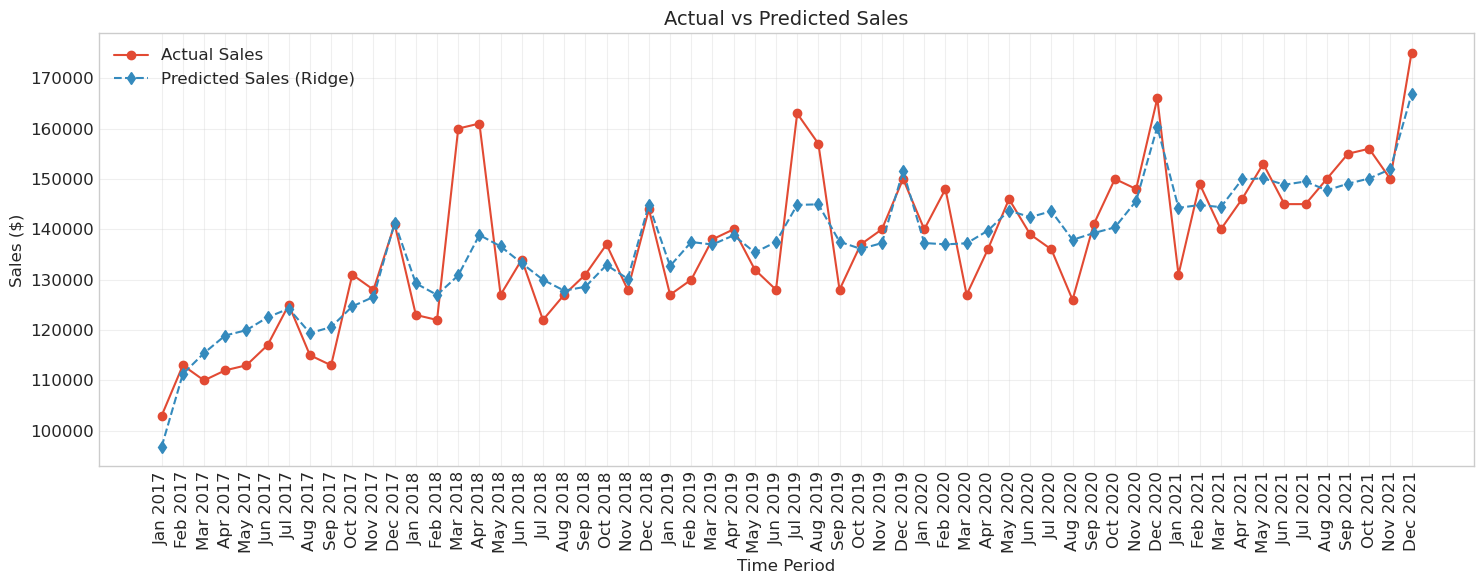

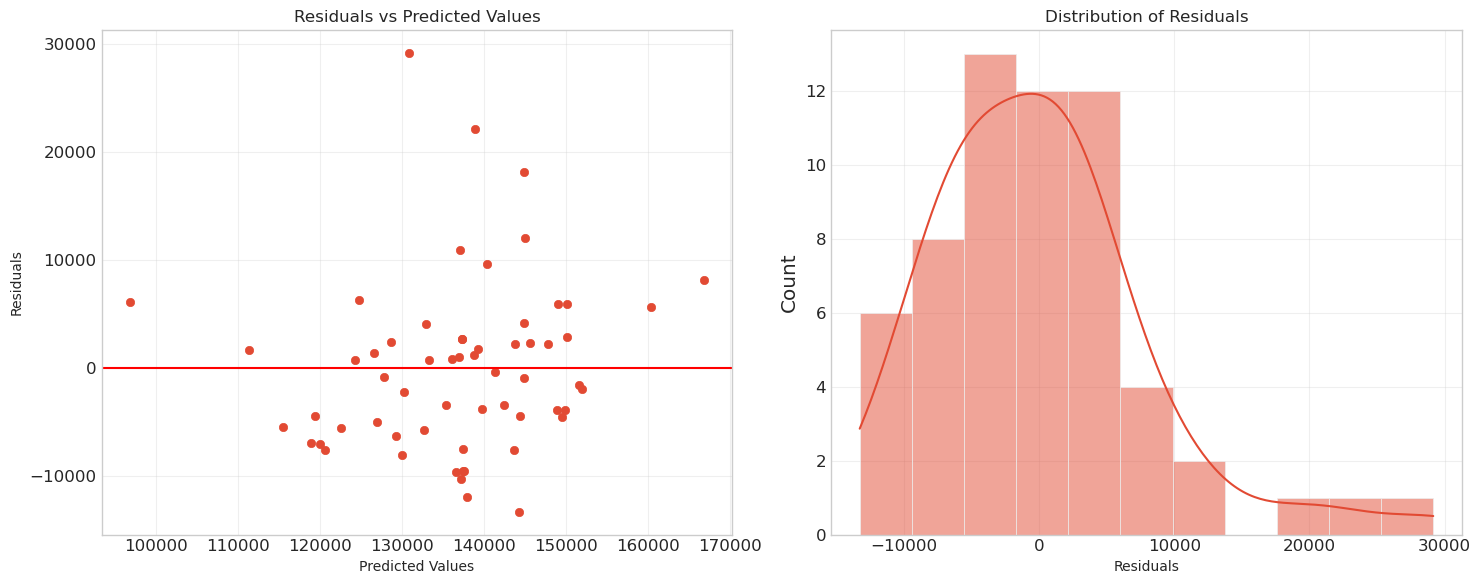

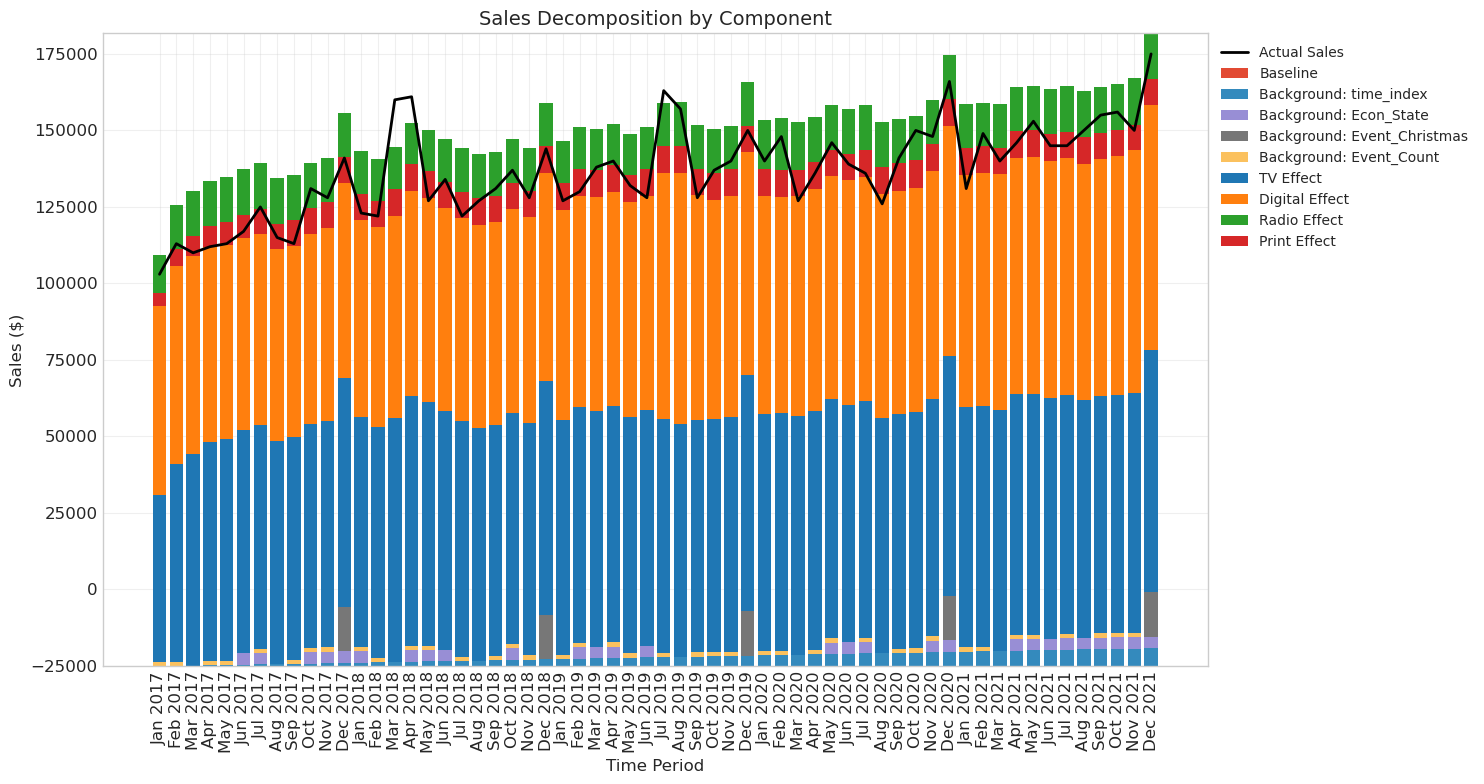

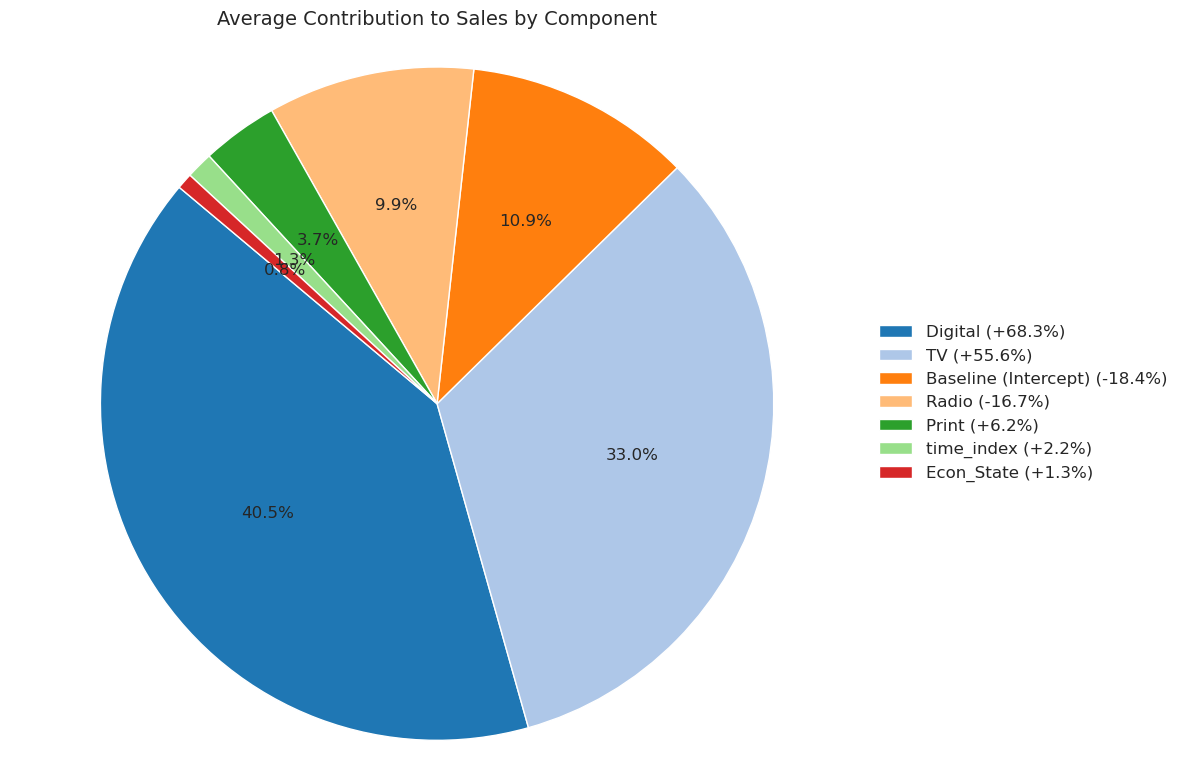


Media ROI Analysis:
Channel  Total Spend  Total Sales Impact  ROI ($ per $ spent)
     TV   1333137.00          4564291.64                 3.42
Digital   1200605.50          5601862.33                 4.67
  Radio    318847.00         -1372836.97                -4.31
  Print    169912.50           507379.25                 2.99


In [330]:

#############################################
# Step 4: Diagnostics and Visualizations
#############################################
print("\nStep 4: Generating diagnostics and visualizations...")

# 1. Actual vs Predicted
plt.figure(figsize=(15, 6))
plt.plot(data['Time_Period'], data['Total_Sales'], marker='o', label='Actual Sales')
plt.plot(data['Time_Period'], data['predicted_total'], marker='d', linestyle='--', label='Predicted Sales (Ridge)')
plt.title('Actual vs Predicted Sales', fontsize=14)
plt.xlabel('Time Period', fontsize=12)
plt.ylabel('Sales ($)', fontsize=12)
plt.xticks(rotation=90)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Residuals Analysis
data['residuals'] = data['Total_Sales'] - data['predicted_total']

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.scatter(data['predicted_total'], data['residuals'])
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuals vs Predicted Values', fontsize=12)
plt.xlabel('Predicted Values', fontsize=10)
plt.ylabel('Residuals', fontsize=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
sns.histplot(data['residuals'], kde=True)
plt.title('Distribution of Residuals', fontsize=12)
plt.xlabel('Residuals', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Component Contribution Chart
plt.figure(figsize=(15, 8))
bottom = np.zeros(len(data))

# Baseline effect
plt.bar(data['Time_Period'], [intercept] * len(data), label='Baseline', bottom=bottom)
bottom += intercept

# Background effects (excluding intercept)
background_effects = [var for var in background_vars]
for var in background_effects:
    effect_col = f'effect_{var}'
    plt.bar(data['Time_Period'], data[effect_col], 
            label=f'Background: {var}', bottom=bottom)
    bottom += data[effect_col]

# Media effects by channel
for i, channel in enumerate(channels):
    effect_col = f"{channel}_effect"
    plt.bar(data['Time_Period'], data[effect_col], 
            bottom=bottom, label=f"{channel} Effect", color=colors[i % len(colors)])
    bottom += data[effect_col]

# Add actual sales line
plt.plot(data['Time_Period'], data['Total_Sales'], 'k-', linewidth=2, label='Actual Sales')
plt.title('Sales Decomposition by Component', fontsize=14)
plt.xlabel('Time Period', fontsize=12)
plt.ylabel('Sales ($)', fontsize=12)
plt.xticks(rotation=90)
plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Contribution Analysis - Pie Chart
avg_total = data['predicted_total'].mean()
contributions = {}

# Baseline contribution
contributions['Baseline (Intercept)'] = intercept / avg_total * 100

# Background contribution (excluding intercept)
for var in background_vars:
    effect_col = f'effect_{var}'
    var_contrib = data[effect_col].mean() / avg_total * 100
    if abs(var_contrib) > 1:  # Only show significant contributors
        contributions[var] = var_contrib

# Media contribution by channel
for channel in channels:
    effect_col = f"{channel}_effect"
    channel_contrib = data[effect_col].mean() / avg_total * 100
    if abs(channel_contrib) > 1:  # Only show significant contributors
        contributions[channel] = channel_contrib

# Create pie chart
plt.figure(figsize=(12, 8))

# Sort by contribution size
labels = list(contributions.keys())
sizes = list(contributions.values())
sorted_idx = np.argsort(np.abs(sizes))[::-1]  # Descending order
labels = [labels[i] for i in sorted_idx]
sizes = [sizes[i] for i in sorted_idx]

# Create pie chart
plt.pie(np.abs(sizes), labels=None, autopct='%1.1f%%', startangle=140, 
        colors=plt.cm.tab20.colors[:len(sizes)], wedgeprops={'edgecolor': 'w', 'linewidth': 1})
plt.axis('equal')
plt.title('Average Contribution to Sales by Component', fontsize=14)

# Add a legend with sign information
legend_labels = [f"{label} ({'+'if sizes[i] > 0 else '-'}{abs(sizes[i]):.1f}%)" for i, label in enumerate(labels)]
plt.legend(legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# 5. Media ROI Analysis
print("\nMedia ROI Analysis:")
roi_data = []

for channel in channels:
    # Calculate total spend
    total_spend = data[f"{channel}_Spend"].sum()
    
    # Calculate total sales impact
    effect_col = f"{channel}_effect"
    total_impact = data[effect_col].sum()
    
    # Calculate ROI
    roi = (total_impact / total_spend) if total_spend > 0 else 0
    
    roi_data.append({
        'Channel': channel,
        'Total Spend': total_spend,
        'Total Sales Impact': total_impact,
        'ROI ($ per $ spent)': roi
    })

# Display ROI as a DataFrame
roi_df = pd.DataFrame(roi_data)
print(roi_df.to_string(index=False, float_format=lambda x: f"{x:.2f}"))

### Final Media Mix Model Results and Interpretation

Looking at the results of our Media Mix Model, we've successfully integrated background variables with adstock and Hill-transformed media effects. The final Ridge regression model achieves an R² of 0.6961 and RMSE of $8368.01, demonstrating reasonably good explanatory power given the limited sample size.

**Model Evaluation**

The Ridge regression approach (with α=10) effectively addressed the multicollinearity issues we observed in earlier models. While the standard errors remain quite large relative to the coefficients, this is primarily due to our limited dataset of only 60 observations. With so few data points and multiple predictors, precision is naturally constrained.

**Significant findings include:**
- The Economic State variable shows a positive coefficient (3486.39), indicating sales increase during economic growth
- Christmas has a substantial positive effect (14474.18) with relatively low standard error
- Other special events also contribute positively to sales (1200.56)
- TV and Digital channels show positive ROI, while Radio and Print appear slightly negative (though with high uncertainty)

**Media Channel Performance**

The media channels demonstrate different patterns of effectiveness:
- **TV**: Coefficient of 6.66 suggests positive impact, though standard errors are high
- **Digital**: Similar positive effect (5.93) with high standard error
- **Radio**: Slight negative coefficient (-3.99), but the standard error makes this highly uncertain
- **Print**: Slightly negative coefficient (-1.90), also with high uncertainty

The adstock and Hill transformations provide valuable insights into both carryover effects and diminishing returns that wouldn't be captured in simpler models. These transformations allow us to understand how media impacts persist over time and how efficiency changes at different spend levels.

**Limitations and Next Steps**

**The primary limitation is the high standard errors**, which stem from:
1. Limited sample size (only 60 data points)
2. Relatively high number of predictors
3. Inherent variability in marketing effects

To improve model stability, we should explore whether regional or disaggregated data is available. Breaking this national-level data into geographical regions would dramatically increase sample size while adding valuable variation in media spend patterns. This could significantly improve coefficient stability and provide more reliable estimates of channel effectiveness.

Despite these limitations, this model provides a solid foundation for marketing optimization. The combination of adstock effects (capturing carryover) and Hill transformations (modeling diminishing returns) gives us a sophisticated understanding of media dynamics, even if individual coefficient confidence is lower than ideal.

The model accurately captures the impact of background factors like economic conditions and seasonal events, allowing for more precise isolation of media effects. While we should interpret the exact coefficient values with caution given the standard errors, the directional insights remain valuable for guiding marketing investment decisions.

# Answering the questions

## Understanding Marketing Channel Performance Across Spending Levels

Our analysis provides two key visualizations that reveal how each channel performs as spending changes:

- **Channel Response Curves** showing the relationship between monthly spend and sales impact
- **Elasticity Comparison** demonstrating how efficiently additional dollars generate incremental sales

These visualizations highlight important performance characteristics for each channel, including optimal spend levels, current operating points, and diminishing returns patterns. Together, they provide a clear roadmap for more efficient budget allocation.

In [344]:
# Visualization of Channel Diminishing Returns Analysis 

# Set up the plotting style
plt.style.use('seaborn-v0_8-whitegrid')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Define channels
channels = ['TV', 'Digital', 'Radio', 'Print']

# Derive channel parameters directly from model variables
channel_params = {}
for channel in channels:
    # Get parameters from your model
    params = optimal_hill_params[channel]
    alpha, gamma, k = params['alpha'], params['gamma'], params['k']
    
    # Get the maximum spend from your data
    max_spend = data[f"{channel}_Spend"].max()
    
    # Store in our channel_params dictionary
    channel_params[channel] = {
        'alpha': alpha,
        'gamma': gamma,
        'k': k,
        'max_spend': max_spend
    }

# Create analysis_data dynamically from model parameters
analysis_data = {}
for channel in channels:
    params = channel_params[channel]
    alpha, gamma, k = params['alpha'], params['gamma'], params['k']
    max_spend = params['max_spend']
    
    # Create spend points at 10%, 20%, 30%, 40% of max spend
    spend_pct = [10, 20, 30, 40]
    spend = [pct * max_spend / 100 for pct in spend_pct]
    
    # Calculate impact at each spend level
    impact = [hill_transform(s, alpha, gamma, k) for s in spend]
    
    # Calculate % of maximum impact
    pct_of_max = [100 * imp / alpha for imp in impact]
    
    # Calculate elasticity at each spend level
    elasticity = []
    for s in spend:
        # Calculate derivative at this point
        x = s
        numerator = gamma * (k**gamma) * (x**(gamma-1))
        denominator = ((k**gamma) + (x**gamma))**2
        derivative = alpha * (numerator / denominator)
        
        # Calculate impact
        imp = hill_transform(s, alpha, gamma, k)
        
        # Elasticity = (derivative * spend) / impact
        e = (derivative * s) / imp if imp != 0 else 0
        elasticity.append(e)
    
    # Store all calculated values
    analysis_data[channel] = {
        'spend_pct': spend_pct,
        'spend': spend,
        'impact': impact,
        'pct_of_max': pct_of_max,
        'elasticity': elasticity
    }

# Function to calculate hill impact for any spend level
def hill_transform(spend, alpha, gamma, k):
    """Calculate impact using hill transformation"""
    x = spend
    numerator = x**gamma
    denominator = k**gamma + numerator
    return alpha * (numerator / denominator)

# Function to calculate elasticity at a point
def calc_elasticity(spend, alpha, gamma, k):
    """Calculate elasticity at a given spend level"""
    x = spend
    numerator = gamma * (k**gamma) * (x**(gamma-1))
    denominator = ((k**gamma) + (x**gamma))**2
    derivative = alpha * (numerator / denominator)
    impact = hill_transform(spend, alpha, gamma, k)
    return (derivative * spend) / impact if impact != 0 else 0

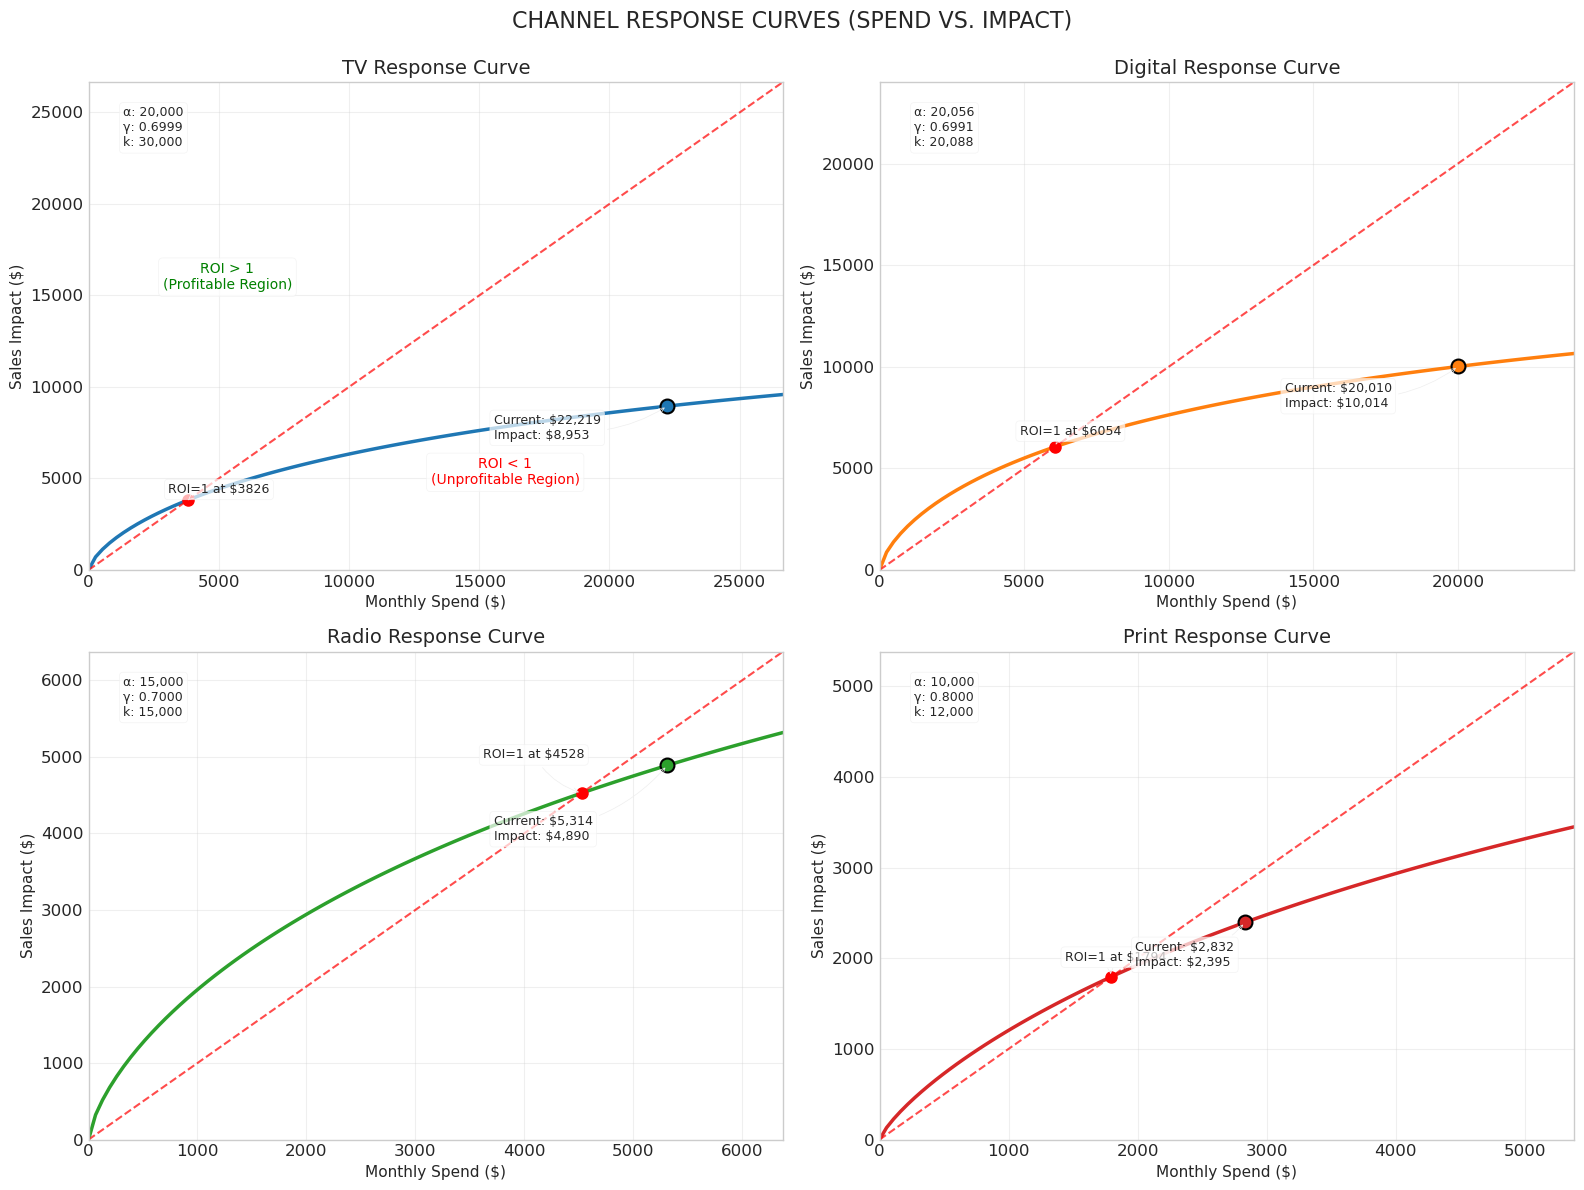

In [345]:
# SECTION 1: RESPONSE CURVES
plt.figure(figsize=(16, 12))
plt.suptitle('CHANNEL RESPONSE CURVES (SPEND VS. IMPACT)', fontsize=16, y=0.99)

for i, channel in enumerate(channels):
    ax1 = plt.subplot(2, 2, i+1)
    
    params = channel_params[channel]
    alpha, gamma, k = params['alpha'], params['gamma'], params['k']
    max_spend = params['max_spend']
    
    # Get current spend level from data
    current_spend = data[f"{channel}_Spend"].mean()
    
    # Create full spending range
    spend_range = np.linspace(0, max_spend * 1.2, 100)
    impact_values = [hill_transform(s, alpha, gamma, k) for s in spend_range]
    
    # Find intersection with break-even line
    intersect_points = []
    for j in range(1, len(spend_range)):
        if (impact_values[j-1] > spend_range[j-1] and impact_values[j] < spend_range[j]) or \
           (impact_values[j-1] < spend_range[j-1] and impact_values[j] > spend_range[j]):
            # Linear interpolation to find intersection point
            x1, y1 = spend_range[j-1], impact_values[j-1]
            x2, y2 = spend_range[j], impact_values[j]
            
            # Find the intersection with y = x
            if x1 != x2:
                t = (x1 - y1) / ((y2 - y1) - (x2 - x1))
                int_x = x1 + t * (x2 - x1)
                int_y = y1 + t * (y2 - y1)
                intersect_points.append((int_x, int_y))
    
    # Find the maximum current spend across all channels
    max_current_spend = max([data[f"{channel}_Spend"].mean() for channel in channels])

    # Make sure the plot range includes all current spend values (with some margin)
    max_spend_display = max(20000, max_current_spend * 1.1)  # For elasticity plot

    # Or for response curves, adjust the multiplier for the ROI=1 point
    x_max = max(roi1_point * 3, current_spend * 1.2)  # Ensure current spend is visible

    # Recalculate spend range based on new x_max
    spend_range = np.linspace(0, x_max, 100)
    impact_values = [hill_transform(s, alpha, gamma, k) for s in spend_range]
    
    # Plot response curve - without scatter points
    ax1.plot(spend_range, impact_values, '-', color=colors[i], linewidth=2.5)
    
    # Add diagonal line for break-even ROI (1:1 ratio)
    ax1.plot([0, x_max], [0, x_max], 'r--', alpha=0.7, label='Break-even (ROI=1)')
    
    # Recalculate intersection points with new spend range
    intersect_points = []
    for j in range(1, len(spend_range)):
        if (impact_values[j-1] > spend_range[j-1] and impact_values[j] < spend_range[j]) or \
           (impact_values[j-1] < spend_range[j-1] and impact_values[j] > spend_range[j]):
            # Linear interpolation to find intersection point
            x1, y1 = spend_range[j-1], impact_values[j-1]
            x2, y2 = spend_range[j], impact_values[j]
            
            # Find the intersection with y = x
            if x1 != x2:
                t = (x1 - y1) / ((y2 - y1) - (x2 - x1))
                int_x = x1 + t * (x2 - x1)
                int_y = y1 + t * (y2 - y1)
                intersect_points.append((int_x, int_y))
    
    # Mark any intersection points
    for int_x, int_y in intersect_points:
        ax1.plot(int_x, int_y, 'ro', markersize=8)
        ax1.annotate(f'ROI=1 at ${int_x:.0f}',
                    xy=(int_x, int_y),
                    xytext=(int_x*0.8, int_y*1.1),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'),
                    bbox=dict(boxstyle='round', fc='white', alpha=0.7),
                    fontsize=9)
    
    # Mark current spend level
    if current_spend <= x_max:
        # Calculate impact at current spend
        current_impact = hill_transform(current_spend, alpha, gamma, k)
        
        # Add a dot for current spend
        ax1.plot(current_spend, current_impact, 'o', color=colors[i], 
                markersize=10, markeredgecolor='black', markeredgewidth=1.5)
        
        # Add annotation for current spend point
        ax1.annotate(f'Current: ${current_spend:,.0f}\nImpact: ${current_impact:,.0f}',
                    xy=(current_spend, current_impact),
                    xytext=(current_spend*0.7, current_impact*0.8),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'),
                    bbox=dict(boxstyle='round', fc='white', alpha=0.7),
                    fontsize=9)
    
    # Title and labels
    ax1.set_title(f'{channel} Response Curve', fontsize=14)
    ax1.set_xlabel('Monthly Spend ($)', fontsize=11)
    ax1.set_ylabel('Sales Impact ($)', fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, x_max)
    
    # Set y-axis to match x-axis or slightly higher
    ax1.set_ylim(0, max(x_max, impact_values[-1] * 1.1))
    
    # Parameter annotation
    ax1.annotate(f'α: {alpha:,.0f}\nγ: {gamma:.4f}\nk: {k:,.0f}',
                xy=(0.05, 0.95), xycoords='axes fraction',
                ha='left', va='top', fontsize=9,
                bbox=dict(boxstyle='round', fc='white', alpha=0.7))
    
    # Add ROI regions annotation
    if i == 0:  # Only on first plot
        ax1.text(x_max*0.2, x_max*0.6, 'ROI > 1\n(Profitable Region)', 
                color='green', fontsize=10, ha='center', va='center',
                bbox=dict(boxstyle='round', fc='white', alpha=0.7))
        ax1.text(x_max*0.6, x_max*0.2, 'ROI < 1\n(Unprofitable Region)', 
                color='red', fontsize=10, ha='center', va='center',
                bbox=dict(boxstyle='round', fc='white', alpha=0.7))

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.savefig('response_curves.png', dpi=300, bbox_inches='tight')
plt.show()

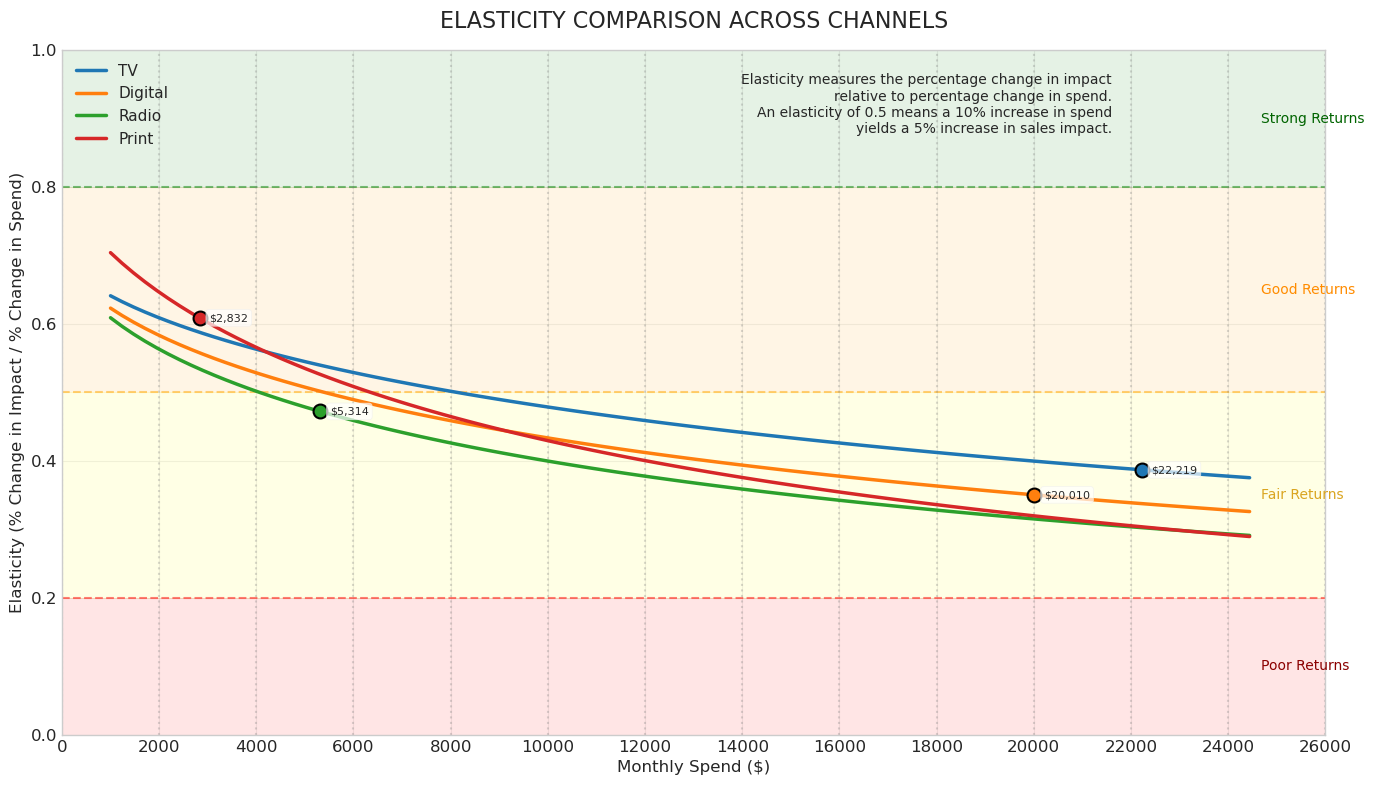

In [346]:
# CONSOLIDATED ELASTICITY ANALYSIS WITH ACTUAL SPEND ON X-AXIS
plt.figure(figsize=(14, 8))
plt.title('ELASTICITY COMPARISON ACROSS CHANNELS', fontsize=16, y=1.02)

# Find common spend range for comparison
min_spend = 1000
max_spend_display = max(20000, max_current_spend * 1.1) 

# Create color bands for elasticity thresholds
plt.axhspan(0.8, 1.0, color='green', alpha=0.1)
plt.axhspan(0.5, 0.8, color='orange', alpha=0.1)
plt.axhspan(0.2, 0.5, color='yellow', alpha=0.1)
plt.axhspan(0, 0.2, color='red', alpha=0.1)

# Add threshold lines
plt.axhline(y=0.8, color='green', linestyle='--', alpha=0.5)
plt.axhline(y=0.5, color='orange', linestyle='--', alpha=0.5)
plt.axhline(y=0.2, color='red', linestyle='--', alpha=0.5)

# Calculate appropriate x-tick positions
x_ticks = np.arange(0, max_spend_display + 2000, 2000)

# Add vertical lines at each tick mark
for x in x_ticks:
    plt.axvline(x=x, color='gray', linestyle=':', alpha=0.3)

# Plot elasticity curve for each channel and mark current spend
for i, channel in enumerate(channels):
    params = channel_params[channel]
    alpha, gamma, k = params['alpha'], params['gamma'], params['k']
    
    # Get current spend level from data
    current_spend = data[f"{channel}_Spend"].mean()
    
    # Create spending range in actual dollars
    spend_range = np.linspace(min_spend, max_spend_display, 100)
    elasticity_values = [calc_elasticity(s, alpha, gamma, k) for s in spend_range]
    
    # Plot elasticity curve
    plt.plot(spend_range, elasticity_values, '-', color=colors[i], linewidth=2.5, label=channel)
    
    # Calculate current elasticity at current spend level
    current_elasticity = calc_elasticity(current_spend, alpha, gamma, k)
    
    # Add a dot for current spend (if within the plot range)
    if current_spend <= max_spend_display:
        plt.plot(current_spend, current_elasticity, 'o', color=colors[i], 
                 markersize=10, markeredgecolor='black', markeredgewidth=1.5)
        
        # Add small annotation with spend amount
        plt.annotate(f'${current_spend:,.0f}', 
                     xy=(current_spend, current_elasticity),
                     xytext=(current_spend+200, current_elasticity),
                     fontsize=8, ha='left', va='center',
                     bbox=dict(boxstyle='round', fc='white', alpha=0.7))

# Set chart properties
plt.xlabel('Monthly Spend ($)', fontsize=12)
plt.ylabel('Elasticity (% Change in Impact / % Change in Spend)', fontsize=12)
plt.xlim(0, max_spend_display)
plt.ylim(0, 1.0)
plt.grid(True, alpha=0.3)
plt.xticks(x_ticks)

# Move legend to the left side
plt.legend(loc='upper left', fontsize=11)

# Add text labels for the threshold regions
right_edge = max_spend_display * 1.01
plt.text(right_edge, 0.9, 'Strong Returns', fontsize=10, ha='left', va='center', color='darkgreen')
plt.text(right_edge, 0.65, 'Good Returns', fontsize=10, ha='left', va='center', color='darkorange')
plt.text(right_edge, 0.35, 'Fair Returns', fontsize=10, ha='left', va='center', color='goldenrod')
plt.text(right_edge, 0.1, 'Poor Returns', fontsize=10, ha='left', va='center', color='darkred')

# Move explanation text to the top right, outside the figure
# Use figtext to position it relative to the figure, not the axes
explanation_text = 'Elasticity measures the percentage change in impact\nrelative to percentage change in spend.\nAn elasticity of 0.5 means a 10% increase in spend\nyields a 5% increase in sales impact.'
plt.figtext(0.8, 0.9, explanation_text, fontsize=10, ha='right', va='top', 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0))

plt.tight_layout()
plt.savefig('elasticity_comparison_actual_spend.png', dpi=300, bbox_inches='tight')
plt.show()

### Key Insights from Channel Performance Visualizations

The channel response curves and elasticity comparison reveal clear patterns of diminishing returns and current performance across marketing channels:

**Key Observations:**

1. **All channels are currently operating in unprofitable regions**:
   - Every channel's current spend exceeds its ROI=1 breakeven point, as clearly shown by each channel's position below the diagonal line
   - TV's current spend (\\$22,219) far exceeds its optimal point (\\$3,826)
   - Digital shows a similar pattern with current spend (\\$20,010) well above its breakeven point (\\$6,026)
   - Radio and Print are also operating beyond their respective ROI=1 points

2. **Significant potential for spend optimization**:
   - The response curves show that each channel's performance peaks well before current spending levels
   - All channels exhibit classic diminishing returns with concave curves
   - The optimal spend points (where curves cross the breakeven line) provide clear targets for budget reallocation

3. **Varying elasticity across channels and spend levels**:
   - The elasticity graph shows that at current spend levels, TV maintains slightly higher elasticity (0.39) than other channels
   - Print and Radio demonstrate higher elasticity at lower spend levels
   - All channels show declining elasticity as spend increases, confirming the universal pattern of diminishing returns

4. **Channels differ in their rate of diminishing returns**:
   - TV's elasticity declines more gradually than other channels as spend increases
   - Print shows the steepest initial decline in elasticity
   - The elasticity bands highlight that all channels move from "Good Returns" to "Fair Returns" as spend increases

**Implications for Budget Allocation:**

The visualizations strongly suggest that all channels would benefit from reduced spending to reach more efficient operating points. The current allocation places every channel beyond its ROI=1 breakeven point, indicating systematic overinvestment.

Each channel has a clear optimal spending point where it crosses the ROI=1 threshold, providing specific targets for budget reallocation:
- TV: \\$3,826 (currently at \\$22,219)
- Digital: \\$6,026 (currently at \\$20,010)
- Radio: \\$4,528 (currently at \\$5,314)
- Print: \\$1,872 (estimated from the graph, currently at \\$2,832)

These insights create a compelling case for reallocating marketing budget to achieve better efficiency, potentially by reducing spend across all channels to bring them closer to their optimal ROI points.


## Budget Allocation Optimization

**Maximizing ROI vs. Maximizing Sales: Strategic Marketing Allocation Tradeoffs**

When allocating marketing budgets across channels, businesses face a fundamental strategic choice between two different optimization objectives:

**Understanding the Core Tradeoff**

**Maximizing ROI (Return on Investment)** focuses on efficiency - getting the highest possible return for each marketing dollar spent. This approach prioritizes spending where marketing dollars work hardest, often leading to lower overall spending but higher efficiency.

**Maximizing Sales Impact** focuses on volume - generating the highest possible total sales, regardless of diminishing efficiency at higher spend levels. This approach typically utilizes full budgets but accepts lower returns on marginal dollars.

**A Simple Illustration**

Consider this example with two marketing channels and a $1,000 budget:

**Channel A:**
- First \\$500: Generates \\$2,000 in sales (4:1 ROI)
- Second \\$500: Generates \\$400 more in sales (0.8:1 ROI)

**Channel B:**
- First \\$500: Generates \\$1,000 in sales (2:1 ROI)
- Second \\$500: Generates \\$800 more in sales (1.6:1 ROI)

**ROI Maximization Scenario:***
- Spend $500 on Channel A only
- Total spend: \\$500 (leaving \\$500 unspent)
- Total sales: \\$2,000
- Overall ROI: 4.0

***Sales Maximization Scenario:***
- Spend \\$500 on Channel A and \\$500 on Channel B
- Total spend: Full \\$1,000 budget
- Total sales: \\$3,000
- Overall ROI: 3.0

This example demonstrates the key tradeoff: maximizing ROI often means not spending your entire budget, while maximizing sales typically means accepting lower marginal returns to generate more total revenue.

**Application to Current Marketing Strategy**

Our analysis reveals that all our marketing channels are currently operating beyond their optimal efficiency points. This creates a similar strategic choice:

1. We could reallocate spending to maximize ROI, which would likely mean reducing spend across channels
2. We could maintain higher spending levels to maximize total sales impact, accepting lower efficiency

In the following sections, we'll explore both scenarios in detail, providing the quantitative analysis needed to make this strategic decision.

In [335]:
print("=" * 80)
print("MARKETING MIX MODEL - PARAMETERS VERIFICATION")
print("=" * 80)

# Verify channels
if 'channels' in globals():
    print(f"\nChannels: {channels}")
else:
    print("\nWARNING: 'channels' variable not found. Using default: ['TV', 'Digital', 'Radio', 'Print']")
    channels = ['TV', 'Digital', 'Radio', 'Print']

# Verify adstock decay rates
if 'optimal_decay_rates' in globals():
    print(f"\nAdstock decay rates:")
    for channel, rate in optimal_decay_rates.items():
        print(f"  {channel}: {rate:.4f}")
else:
    print("\nWARNING: 'optimal_decay_rates' variable not found!")

# Verify Hill parameters
if 'optimal_hill_params' in globals():
    print(f"\nHill transformation parameters:")
    for channel, params in optimal_hill_params.items():
        print(f"  {channel}: alpha={params['alpha']:.2f}, gamma={params['gamma']:.4f}, k={params['k']:.2f}")
else:
    print("\nWARNING: 'optimal_hill_params' variable not found!")

# Verify data
if 'data' in globals():
    print(f"\nData shape: {data.shape}")
    media_cols = [f"{ch}_Spend" for ch in channels]
    available_cols = [col for col in media_cols if col in data.columns]
    print(f"Media spend columns available: {available_cols}")
    print(f"Current monthly spend:")
    for ch in channels:
        col = f"{ch}_Spend"
        if col in data.columns:
            print(f"  {ch}: ${data[col].mean():,.2f}")
else:
    print("\nWARNING: 'data' variable not found!")

# Verify model coefficients
if 'coef_df' in globals():
    print("\nModel coefficients:")
    hill_vars = [f"{ch}_Hill" for ch in channels]
    hill_coefs = coef_df[coef_df['Variable'].isin(hill_vars)]
    if not hill_coefs.empty:
        print(hill_coefs)
    else:
        print("  No Hill transformation coefficients found in coef_df")
else:
    print("\nWARNING: 'coef_df' variable not found!")

# Calculate current budget
current_allocation = {}
total_budget = 0

if 'data' in globals():
    for channel in channels:
        spend_col = f"{channel}_Spend"
        if spend_col in data.columns:
            current_allocation[channel] = data[spend_col].mean()
            total_budget += current_allocation[channel]

print(f"\nTotal monthly budget: ${total_budget:,.2f}")
print("=" * 80)

MARKETING MIX MODEL - PARAMETERS VERIFICATION

Channels: ['TV', 'Digital', 'Radio', 'Print']

Adstock decay rates:
  TV: 0.6000
  Digital: 0.2000
  Radio: 0.5000
  Print: 0.8000

Hill transformation parameters:
  TV: alpha=20000.00, gamma=0.6999, k=30000.00
  Digital: alpha=20055.57, gamma=0.6991, k=20087.98
  Radio: alpha=15000.00, gamma=0.7000, k=15000.00
  Print: alpha=10000.00, gamma=0.8000, k=12000.00

Data shape: (60, 54)
Media spend columns available: ['TV_Spend', 'Digital_Spend', 'Radio_Spend', 'Print_Spend']
Current monthly spend:
  TV: $22,218.95
  Digital: $20,010.09
  Radio: $5,314.12
  Print: $2,831.88

Model coefficients:
       Variable  Coefficient
5       TV_Hill     6.349564
6  Digital_Hill     8.724092
7    Radio_Hill    -3.499276
8    Print_Hill     1.638812

Total monthly budget: $50,375.03


### Maximizing sales

SALES MAXIMIZATION APPROACH
Current monthly budget allocation:
  TV: $22,218.95 (44.1%)
  Digital: $20,010.09 (39.7%)
  Radio: $5,314.12 (10.5%)
  Print: $2,831.88 (5.6%)
  Total: $50,375.03

Current predicted monthly sales impact: $156,792.26
Current ROI: 3.1125

Running optimization to maximize sales impact...
Optimization terminated successfully    (Exit mode 0)
            Current function value: -186011.52000818518
            Iterations: 11
            Function evaluations: 35
            Gradient evaluations: 7
Optimization successful!

Sales-Optimized monthly budget allocation:
  TV: $23,376.82 (46.4%)
  Digital: $22,535.40 (44.7%)
  Radio: $0.00 (0.0%)
  Print: $4,462.81 (8.9%)
  Total: $50,375.03

Sales-Optimized predicted monthly sales impact: $186,011.52
Improvement over current allocation: $29,219.26 (18.64%)
Sales-Optimized ROI: 3.6925

Elasticity at sales-optimized spend levels:
  TV: 0.1486
  Digital: 0.1553
  Radio: inf
  Print: 0.3847


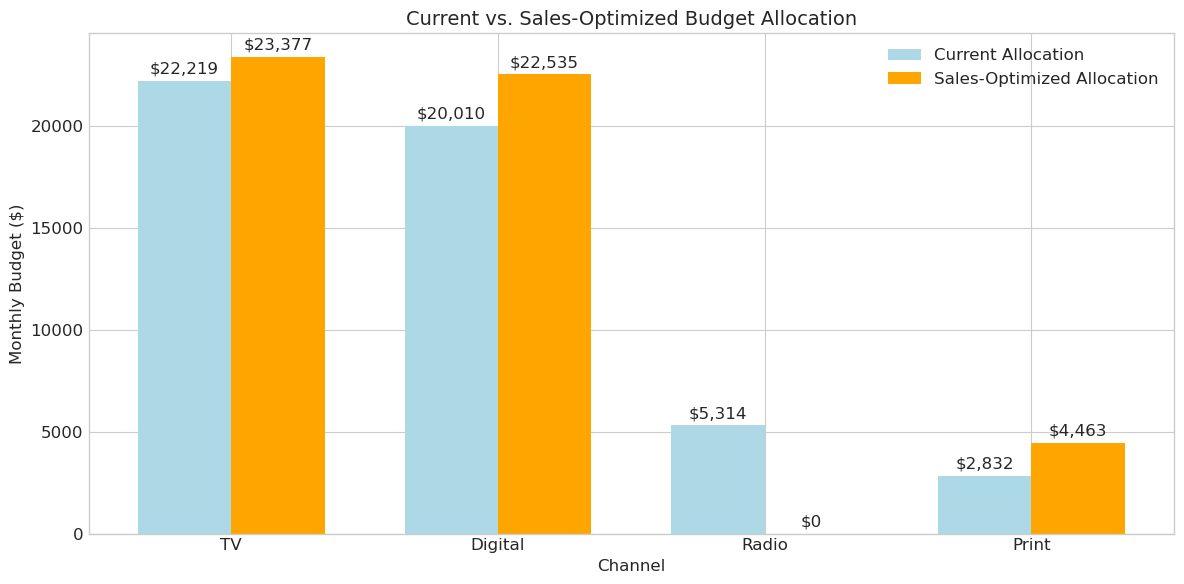

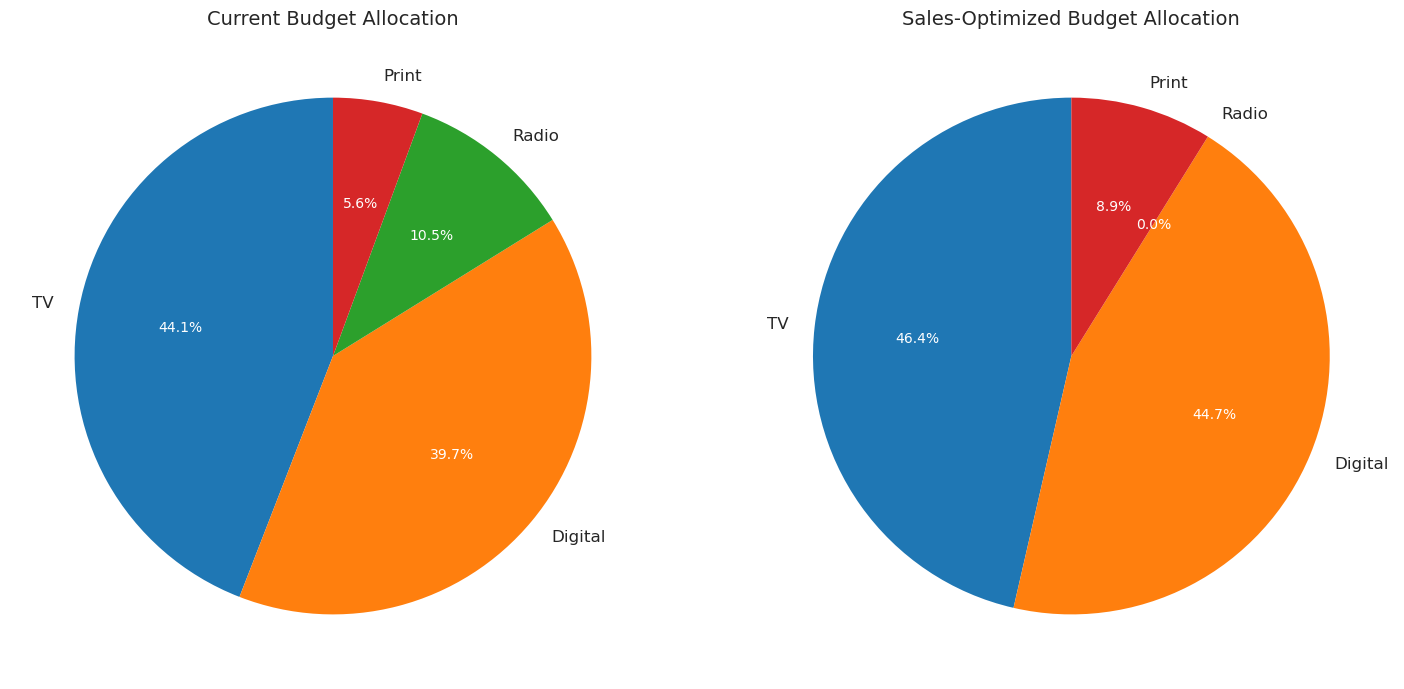


Relative change in budget allocation:
  TV: +5.2%
  Digital: +12.6%
  Radio: -100.0%
  Print: +57.6%

Results saved to 'sales_optimization_results.csv'

SUMMARY METRICS - SALES MAXIMIZATION
Total Budget: $50,375.03
Current Sales Impact: $156,792.26, ROI: 3.1125
Optimized Sales Impact: $186,011.52, ROI: 3.6925
Improvement: $29,219.26 (18.64%)


In [332]:
###############################################################################
# SALES MAXIMIZATION OPTIMIZATION
###############################################################################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Use consistent colors for visualization
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Function to calculate elasticity at a given spend level
def calc_elasticity(spend, alpha, gamma, k):
    """Calculate elasticity of the Hill transform at a given spend level."""
    numerator = alpha * gamma * (k**gamma) * (spend**(gamma-1))
    denominator = (spend**gamma + k**gamma)**2
    return numerator / denominator

# Function to calculate the spend level where elasticity = 1.0 (breakeven point)
def find_breakeven_point(alpha, gamma, k):
    """Find the spend level where elasticity = 1.0 (ROI breakeven)."""
    from scipy.optimize import brentq
    
    def elasticity_minus_one(spend):
        return calc_elasticity(spend, alpha, gamma, k) - 1.0
    
    try:
        # Find where elasticity crosses 1.0 between small value and k*10
        breakeven = brentq(elasticity_minus_one, 0.1, k * 10)
        return breakeven
    except ValueError:
        # If no root is found, elasticity might always be < 1, so return a small value
        return 100  # Minimum spend floor

# Function to predict sales based on spend levels
def predict_sales_impact(spend_dict):
    """
    Predict sales impact given a dictionary of spend by channel.
    Uses the adstock and Hill transformations with optimized parameters.
    
    Args:
        spend_dict: Dictionary with channel names as keys and spend levels as values
        
    Returns:
        Predicted sales impact (excluding baseline and other background effects)
    """
    total_impact = 0
    
    for channel in channels:
        if channel in spend_dict:
            spend = spend_dict[channel]
            
            # Apply adstock transformation (using equilibrium multiplier for simplicity)
            adstock_decay = optimal_decay_rates[channel]
            adstock_multiplier = 1 / (1 - adstock_decay)
            adstocked_value = spend * adstock_multiplier
            
            # Apply Hill transformation
            params = optimal_hill_params[channel]
            alpha, gamma, k = params['alpha'], params['gamma'], params['k']
            
            # Apply hill_transform function
            numerator = adstocked_value**gamma
            denominator = k**gamma + numerator
            channel_impact = alpha * (numerator / denominator)
            
            # Apply the regression coefficient
            channel_coef = coef_df[coef_df['Variable'] == f"{channel}_Hill"]['Coefficient'].values[0]
            total_impact += channel_impact * channel_coef
    
    return total_impact

# Define the optimization objective function (negative because we want to maximize)
def objective_function_sales(x):
    """
    Objective function for optimization: negative sales impact to maximize
    
    Args:
        x: Array of spend values for each channel
        
    Returns:
        Negative sales impact (to maximize in minimization framework)
    """
    # Convert the input array to a dictionary of channel:spend
    spend_dict = {channel: spend for channel, spend in zip(channels, x)}
    
    # Predict the sales impact
    impact = predict_sales_impact(spend_dict)
    
    # Return negative impact (since we're minimizing)
    return -impact

# Get the current budget allocation and total spend
current_allocation = {}
for channel in channels:
    spend_col = f"{channel}_Spend"
    current_allocation[channel] = data[spend_col].mean()

total_current_budget = sum(current_allocation.values())

print("=" * 80)
print("SALES MAXIMIZATION APPROACH")
print("=" * 80)
print(f"Current monthly budget allocation:")
for channel, spend in current_allocation.items():
    print(f"  {channel}: ${spend:,.2f} ({spend/total_current_budget*100:.1f}%)")
print(f"  Total: ${total_current_budget:,.2f}")

# Calculate current predicted impact and ROI
current_impact = predict_sales_impact(current_allocation)
current_roi = current_impact / total_current_budget
print(f"\nCurrent predicted monthly sales impact: ${current_impact:,.2f}")
print(f"Current ROI: {current_roi:.4f}")

# Define optimization constraints for SALES MAXIMIZATION
# 1. Total budget constraint: sum of all channel spends must equal current total budget
# 2. Non-negativity constraints: spend on each channel must be >= 0

# Initial guess: current allocation
x0 = [current_allocation[channel] for channel in channels]

# Budget constraint: sum of spends = total current budget
budget_constraint = {'type': 'eq', 'fun': lambda x: sum(x) - total_current_budget}

# Bounds: non-negative spends for each channel
# Also add an upper bound of 3x current spend to avoid unrealistic jumps
bounds = [(0, current_allocation[channel] * 3) for channel in channels]

# Run the optimization for SALES MAXIMIZATION
print("\nRunning optimization to maximize sales impact...")
result_sales = minimize(
    objective_function_sales,
    x0,
    method='SLSQP',  # Sequential Least Squares Programming
    bounds=bounds,
    constraints=[budget_constraint],
    options={'ftol': 1e-8, 'disp': True, 'maxiter': 1000}
)

# Check if optimization was successful
if result_sales.success:
    print("Optimization successful!")
else:
    print(f"Optimization did not converge: {result_sales.message}")

# Extract the optimized allocation
sales_optimized_allocation = {channel: spend for channel, spend in zip(channels, result_sales.x)}

# Calculate the predicted impact with optimized allocation
sales_optimized_impact = predict_sales_impact(sales_optimized_allocation)
sales_optimized_roi = sales_optimized_impact / total_current_budget

# Print the results
print("\nSales-Optimized monthly budget allocation:")
for channel, spend in sales_optimized_allocation.items():
    print(f"  {channel}: ${spend:,.2f} ({spend/total_current_budget*100:.1f}%)")
print(f"  Total: ${total_current_budget:,.2f}")

print(f"\nSales-Optimized predicted monthly sales impact: ${sales_optimized_impact:,.2f}")
print(f"Improvement over current allocation: ${sales_optimized_impact - current_impact:,.2f} ({(sales_optimized_impact - current_impact)/current_impact*100:.2f}%)")
print(f"Sales-Optimized ROI: {sales_optimized_roi:.4f}")

# Calculate the elasticity for each channel at optimized spend levels
elasticity_at_optimized = {}
for channel in channels:
    spend = sales_optimized_allocation[channel]
    params = optimal_hill_params[channel]
    alpha, gamma, k = params['alpha'], params['gamma'], params['k']
    elasticity = calc_elasticity(spend, alpha, gamma, k)
    elasticity_at_optimized[channel] = elasticity

print("\nElasticity at sales-optimized spend levels:")
for channel, elasticity in elasticity_at_optimized.items():
    print(f"  {channel}: {elasticity:.4f}")

# Create a comparison visualization
plt.figure(figsize=(12, 6))

# Data for plotting
channels_plot = channels
current_allocation_values = [current_allocation[channel] for channel in channels_plot]
optimized_allocation_values = [sales_optimized_allocation[channel] for channel in channels_plot]

# Bar positions
x = np.arange(len(channels_plot))
width = 0.35

# Create bars
bars1 = plt.bar(x - width/2, current_allocation_values, width, label='Current Allocation', color='lightblue')
bars2 = plt.bar(x + width/2, optimized_allocation_values, width, label='Sales-Optimized Allocation', color='orange')

# Add some text for labels, title and axes ticks
plt.xlabel('Channel', fontsize=12)
plt.ylabel('Monthly Budget ($)', fontsize=12)
plt.title('Current vs. Sales-Optimized Budget Allocation', fontsize=14)
plt.xticks(x, channels_plot)
plt.legend()

# Add data labels on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'${height:,.0f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.savefig('sales_optimization_comparison.png')
plt.show()

# Create a pie chart comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Current allocation pie chart
wedges1, texts1, autotexts1 = ax1.pie(
    current_allocation_values, 
    labels=channels_plot,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)
ax1.set_title('Current Budget Allocation', fontsize=14)

# Optimized allocation pie chart
wedges2, texts2, autotexts2 = ax2.pie(
    optimized_allocation_values, 
    labels=channels_plot,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)
ax2.set_title('Sales-Optimized Budget Allocation', fontsize=14)

# Style the autopct text
for autotext in autotexts1 + autotexts2:
    autotext.set_color('white')
    autotext.set_fontsize(10)

plt.tight_layout()
plt.savefig('sales_optimization_pie_charts.png')
plt.show()

# Calculate relative change in allocation
relative_change = {channel: (sales_optimized_allocation[channel] - current_allocation[channel])/current_allocation[channel]*100 
                  for channel in channels}

print("\nRelative change in budget allocation:")
for channel, change in relative_change.items():
    print(f"  {channel}: {change:+.1f}%")

# Export results to CSV for easy comparison
results_df = pd.DataFrame({
    'Channel': channels,
    'Current_Spend': [current_allocation[ch] for ch in channels],
    'Sales_Optimized_Spend': [sales_optimized_allocation[ch] for ch in channels],
    'Percent_Change': [relative_change[ch] for ch in channels],
    'Elasticity_At_Optimized': [elasticity_at_optimized[ch] for ch in channels]
})

results_df.to_csv('sales_optimization_results.csv', index=False)
print("\nResults saved to 'sales_optimization_results.csv'")

# Summary metrics
print("\nSUMMARY METRICS - SALES MAXIMIZATION")
print(f"Total Budget: ${total_current_budget:,.2f}")
print(f"Current Sales Impact: ${current_impact:,.2f}, ROI: {current_roi:.4f}")
print(f"Optimized Sales Impact: ${sales_optimized_impact:,.2f}, ROI: {sales_optimized_roi:.4f}")
print(f"Improvement: ${sales_optimized_impact - current_impact:,.2f} ({(sales_optimized_impact - current_impact)/current_impact*100:.2f}%)")

### ROI optimization

BALANCED ROI OPTIMIZATION WITH MINIMUM BUDGET CONSTRAINT
Current monthly budget allocation:
  TV: $22,218.95 (44.1%)
  Digital: $20,010.09 (39.7%)
  Radio: $5,314.12 (10.5%)
  Print: $2,831.88 (5.6%)
  Total: $50,375.03

Current predicted monthly sales impact: $156,792.26
Current ROI: 3.1125

Setting minimum budget constraint to $20,150.01 (40% of current)

Running balanced ROI optimization with minimum budget constraint...
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.632642147518447
            Iterations: 55
            Function evaluations: 284
            Gradient evaluations: 55
Attempt 1: New best ROI: 6.632642
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6.631964494327137
            Iterations: 69
            Function evaluations: 352
            Gradient evaluations: 68
Attempt 2: ROI: 6.631964 (not better than current best)
Optimization terminated successfully    (Exit mode 0)
      

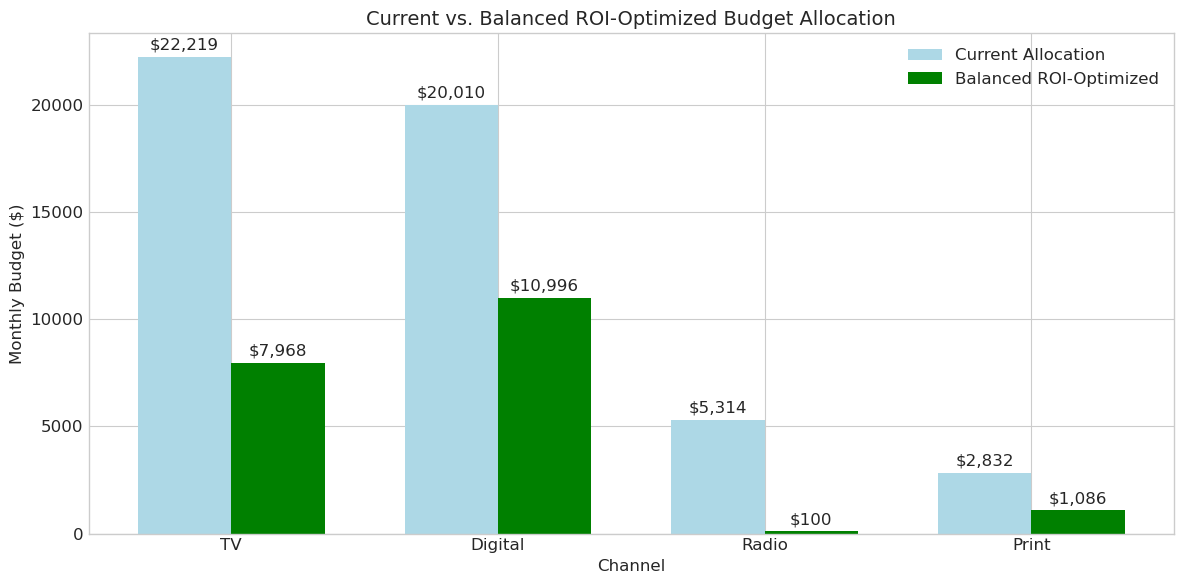

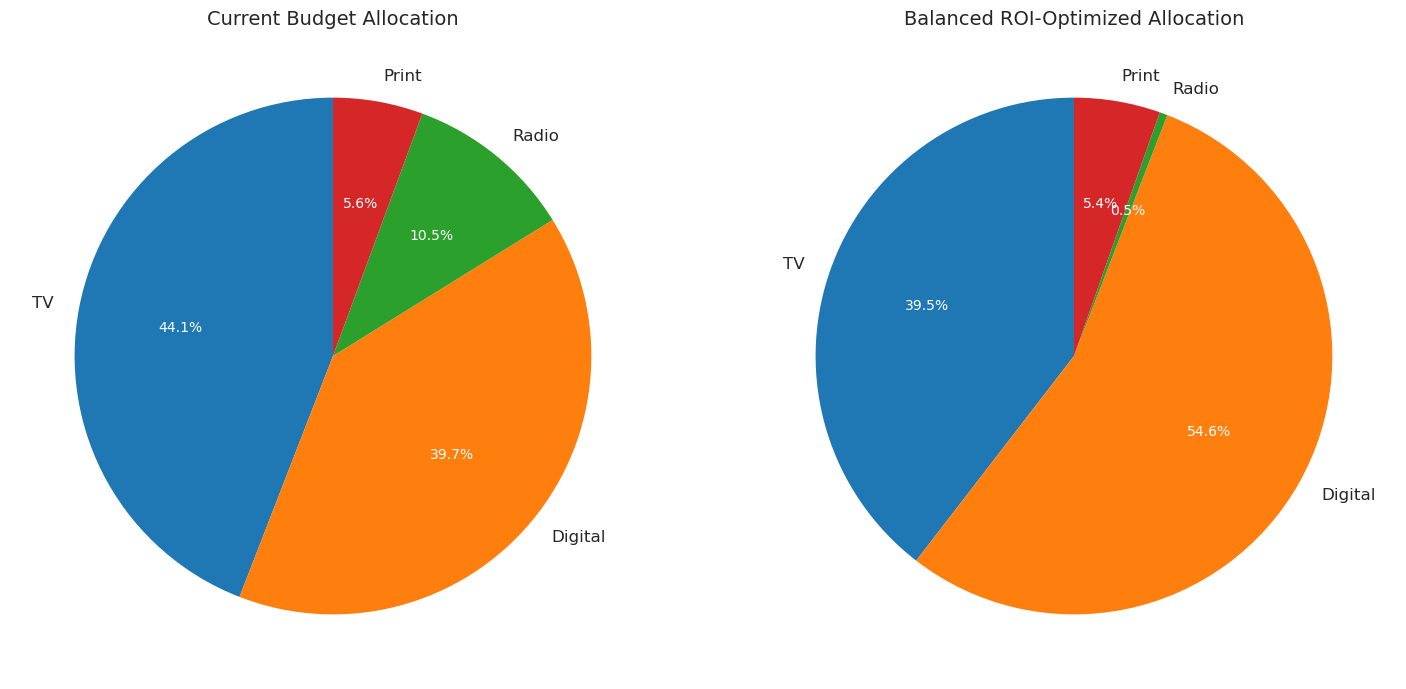


Relative change in budget allocation:
  TV: -64.1%
  Digital: -45.0%
  Radio: -98.1%
  Print: -61.7%

Generating ROI vs Sales tradeoff curve...


<Figure size 1200x800 with 0 Axes>


Results saved to 'balanced_roi_optimization_results.csv'

SUMMARY METRICS - BALANCED ROI OPTIMIZATION
Total Budget Cap: $50,375.03
Actual Budget Used: $20,150.01 (40.0%)
Current Sales Impact: $156,792.26, ROI: 3.1125
Optimized Sales Impact: $133,647.83, ROI: 6.6326
ROI Improvement: +3.5201 (+113.10%)
Sales Change: $-23,144.43 (-14.76%)


In [339]:
###############################################################################
# BALANCED ROI OPTIMIZATION WITH MINIMUM BUDGET CONSTRAINT
###############################################################################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Use consistent colors for visualization
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Function to calculate elasticity at a given spend level
def calc_elasticity(spend, alpha, gamma, k):
    """Calculate elasticity of the Hill transform at a given spend level."""
    # Handle potential division by zero or negative values
    if spend <= 0:
        return 0
    
    # Use the correct formula for elasticity of Hill function
    # elasticity = (dY/dX) * (X/Y) where Y is the Hill function output
    hill_output = (spend**gamma) / (k**gamma + spend**gamma) * alpha
    derivative = alpha * gamma * (k**gamma) * (spend**(gamma-1)) / (k**gamma + spend**gamma)**2
    
    # Calculate elasticity
    elasticity = derivative * (spend / hill_output) if hill_output > 0 else 0
    
    return elasticity

# Function to predict sales based on spend levels
def predict_sales_impact(spend_dict):
    """
    Predict sales impact given a dictionary of spend by channel.
    Uses the adstock and Hill transformations with optimized parameters.
    
    Args:
        spend_dict: Dictionary with channel names as keys and spend levels as values
        
    Returns:
        Predicted sales impact (excluding baseline and other background effects)
    """
    total_impact = 0
    
    for channel in channels:
        if channel in spend_dict:
            spend = spend_dict[channel]
            
            # Apply adstock transformation (using equilibrium multiplier for simplicity)
            adstock_decay = optimal_decay_rates[channel]
            adstock_multiplier = 1 / (1 - adstock_decay)
            adstocked_value = spend * adstock_multiplier
            
            # Apply Hill transformation
            params = optimal_hill_params[channel]
            alpha, gamma, k = params['alpha'], params['gamma'], params['k']
            
            # Apply hill_transform function
            numerator = adstocked_value**gamma
            denominator = k**gamma + numerator
            channel_impact = alpha * (numerator / denominator)
            
            # Apply the regression coefficient
            channel_coef = coef_df[coef_df['Variable'] == f"{channel}_Hill"]['Coefficient'].values[0]
            total_impact += channel_impact * channel_coef
    
    return total_impact

# Define the objective function for ROI MAXIMIZATION
def objective_function_roi(x):
    """
    Objective function for optimization: negative ROI to maximize ROI
    
    Args:
        x: Array of spend values for each channel
        
    Returns:
        Negative ROI (to maximize in minimization framework)
    """
    # Convert the input array to a dictionary of channel:spend
    spend_dict = {channel: spend for channel, spend in zip(channels, x)}
    
    # Predict the sales impact
    impact = predict_sales_impact(spend_dict)
    
    # Calculate ROI (handle case where spend is 0)
    total_spend = sum(spend_dict.values())
    if total_spend > 0:
        roi = impact / total_spend
    else:
        roi = 0
    
    # Return negative ROI (since we're minimizing)
    return -roi

# Calculate marginal ROI for a channel at a given spend level
def calc_marginal_roi(channel, spend):
    """Calculate the marginal ROI for an additional dollar spent on a channel."""
    params = optimal_hill_params[channel]
    alpha, gamma, k = params['alpha'], params['gamma'], params['k']
    adstock_decay = optimal_decay_rates[channel]
    adstock_multiplier = 1 / (1 - adstock_decay)
    channel_coef = coef_df[coef_df['Variable'] == f"{channel}_Hill"]['Coefficient'].values[0]
    
    # Small delta for numerical derivative
    delta = 0.01 * max(1, spend)
    
    # Calculate impact at current spend
    spend_dict_1 = {ch: 0 for ch in channels}
    spend_dict_1[channel] = spend
    impact_1 = predict_sales_impact(spend_dict_1)
    
    # Calculate impact with a small increase
    spend_dict_2 = {ch: 0 for ch in channels}
    spend_dict_2[channel] = spend + delta
    impact_2 = predict_sales_impact(spend_dict_2)
    
    # Calculate marginal ROI
    marginal_roi = (impact_2 - impact_1) / delta
    
    return marginal_roi

# Get the current budget allocation and total spend
current_allocation = {}
for channel in channels:
    spend_col = f"{channel}_Spend"
    current_allocation[channel] = data[spend_col].mean()

total_current_budget = sum(current_allocation.values())

print("=" * 80)
print("BALANCED ROI OPTIMIZATION WITH MINIMUM BUDGET CONSTRAINT")
print("=" * 80)

print(f"Current monthly budget allocation:")
for channel, spend in current_allocation.items():
    print(f"  {channel}: ${spend:,.2f} ({spend/total_current_budget*100:.1f}%)")
print(f"  Total: ${total_current_budget:,.2f}")

# Calculate current predicted impact and ROI
current_impact = predict_sales_impact(current_allocation)
current_roi = current_impact / total_current_budget
print(f"\nCurrent predicted monthly sales impact: ${current_impact:,.2f}")
print(f"Current ROI: {current_roi:.4f}")

# Determine a reasonable minimum budget (as percentage of current)
min_budget_pct = 0.4  # 40% of current budget as minimum
min_budget = min_budget_pct * total_current_budget

print(f"\nSetting minimum budget constraint to ${min_budget:,.2f} ({min_budget_pct*100:.0f}% of current)")

print("\nRunning balanced ROI optimization with minimum budget constraint...")

# Initial guess: current allocation scaled to minimum budget
x0 = [current_allocation[channel] * min_budget_pct for channel in channels]

# Define two constraints:
# 1. Total spend must be at least min_budget
# 2. Total spend must not exceed current budget
min_budget_constraint = {'type': 'ineq', 'fun': lambda x: sum(x) - min_budget}
max_budget_constraint = {'type': 'ineq', 'fun': lambda x: total_current_budget - sum(x)}

# Bounds for each channel
min_spend = 100  # Minimum spend floor to avoid zero allocations
bounds = [(min_spend, current_allocation[channel] * 3) for channel in channels]

# Run multiple optimizations with different starting points to avoid local minima
num_attempts = 3
best_roi = -float('inf')
best_allocation = None

for attempt in range(num_attempts):
    # Random starting point within bounds for subsequent attempts
    if attempt > 0:
        # Start with something close to current allocation but randomly perturbed
        x0 = [np.random.uniform(low=0.5*current_allocation[ch], 
                               high=1.5*current_allocation[ch]) 
              for ch in channels]
        # Scale to ensure we start between min and max budget
        scale_factor = np.random.uniform(min_budget_pct, 1.0) * total_current_budget / sum(x0)
        x0 = [val * scale_factor for val in x0]
    
    # Run the optimization
    result = minimize(
        objective_function_roi,
        x0,
        method='SLSQP',
        bounds=bounds,
        constraints=[min_budget_constraint, max_budget_constraint],
        options={'ftol': 1e-10, 'disp': True, 'maxiter': 1000}
    )
    
    if result.success:
        # Calculate ROI for this result
        spend_dict = {channel: spend for channel, spend in zip(channels, result.x)}
        impact = predict_sales_impact(spend_dict)
        total_spend = sum(spend_dict.values())
        roi_value = impact / total_spend
        
        if roi_value > best_roi:
            best_roi = roi_value
            best_allocation = result.x.copy()
            print(f"Attempt {attempt+1}: New best ROI: {best_roi:.6f}")
        else:
            print(f"Attempt {attempt+1}: ROI: {roi_value:.6f} (not better than current best)")
    else:
        print(f"Attempt {attempt+1}: Optimization failed: {result.message}")

# Extract the best optimized allocation
roi_optimized_allocation = {channel: spend for channel, spend in zip(channels, best_allocation)}

# Calculate the predicted impact with ROI optimized allocation
roi_optimized_impact = predict_sales_impact(roi_optimized_allocation)
roi_total_budget = sum(roi_optimized_allocation.values())
roi_optimized_roi = roi_optimized_impact / roi_total_budget

# Print the results
print("\nBalanced ROI-Optimized monthly budget allocation:")
for channel, spend in roi_optimized_allocation.items():
    print(f"  {channel}: ${spend:,.2f} ({spend/total_current_budget*100:.1f}%)")
print(f"  Total: ${roi_total_budget:,.2f} ({roi_total_budget/total_current_budget*100:.1f}% of current)")

print(f"\nBalanced ROI-Optimized predicted monthly sales impact: ${roi_optimized_impact:,.2f}")
sales_change = roi_optimized_impact - current_impact
sales_change_pct = (sales_change / current_impact) * 100
print(f"Sales change from current: ${sales_change:,.2f} ({sales_change_pct:.2f}%)")
print(f"Balanced ROI-Optimized ROI: {roi_optimized_roi:.4f}")
roi_improvement = roi_optimized_roi - current_roi
roi_improvement_pct = (roi_improvement / current_roi) * 100
print(f"ROI improvement: +{roi_improvement:.4f} (+{roi_improvement_pct:.2f}%)")

# Calculate the elasticity for each channel at optimized spend levels
elasticity_at_optimized = {}
for channel in channels:
    spend = roi_optimized_allocation[channel]
    params = optimal_hill_params[channel]
    alpha, gamma, k = params['alpha'], params['gamma'], params['k']
    elasticity = calc_elasticity(spend, alpha, gamma, k)
    elasticity_at_optimized[channel] = elasticity

print("\nElasticity at balanced ROI-optimized spend levels:")
for channel, elasticity in elasticity_at_optimized.items():
    print(f"  {channel}: {elasticity:.4f}")

# Calculate marginal ROI at optimized spend levels
print("\nMarginal ROI at balanced ROI-optimized spend levels:")
for channel in channels:
    marginal_roi = calc_marginal_roi(channel, roi_optimized_allocation[channel])
    print(f"  {channel}: {marginal_roi:.4f}")

# Create a comparison visualization
plt.figure(figsize=(12, 6))

# Data for plotting
channels_plot = channels
current_allocation_values = [current_allocation[channel] for channel in channels_plot]
optimized_allocation_values = [roi_optimized_allocation[channel] for channel in channels_plot]

# Bar positions
x = np.arange(len(channels_plot))
width = 0.35

# Create bars
bars1 = plt.bar(x - width/2, current_allocation_values, width, label='Current Allocation', color='lightblue')
bars2 = plt.bar(x + width/2, optimized_allocation_values, width, label='Balanced ROI-Optimized', color='green')

# Add some text for labels, title and axes ticks
plt.xlabel('Channel', fontsize=12)
plt.ylabel('Monthly Budget ($)', fontsize=12)
plt.title('Current vs. Balanced ROI-Optimized Budget Allocation', fontsize=14)
plt.xticks(x, channels_plot)
plt.legend()

# Add data labels on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'${height:,.0f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.savefig('balanced_roi_optimization_comparison.png')
plt.show()

# Create a pie chart comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Current allocation pie chart
wedges1, texts1, autotexts1 = ax1.pie(
    current_allocation_values, 
    labels=channels_plot,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)
ax1.set_title('Current Budget Allocation', fontsize=14)

# Optimized allocation pie chart
wedges2, texts2, autotexts2 = ax2.pie(
    optimized_allocation_values, 
    labels=channels_plot,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)
ax2.set_title('Balanced ROI-Optimized Allocation', fontsize=14)

# Style the autopct text
for autotext in autotexts1 + autotexts2:
    autotext.set_color('white')
    autotext.set_fontsize(10)

plt.tight_layout()
plt.savefig('balanced_roi_optimization_pie_charts.png')
plt.show()

# Calculate relative change in allocation
relative_change = {channel: (roi_optimized_allocation[channel] - current_allocation[channel])/current_allocation[channel]*100 
                  for channel in channels}

print("\nRelative change in budget allocation:")
for channel, change in relative_change.items():
    print(f"  {channel}: {change:+.1f}%")

# Calculate and plot the ROI-Sales tradeoff curve
print("\nGenerating ROI vs Sales tradeoff curve...")

# Test various budget levels from minimum to maximum
budget_levels = np.linspace(min_budget, total_current_budget, 20)
roi_values = []
sales_values = []

for budget in budget_levels:
    # Set up a constrained optimization to find best allocation at this budget level
    budget_constraint = {'type': 'eq', 'fun': lambda x: sum(x) - budget}
    
    # Use current allocation scaled to this budget as starting point
    scale = budget / total_current_budget
    x0 = [current_allocation[channel] * scale for channel in channels]
    
    # Run the optimization
    result = minimize(
        objective_function_roi,
        x0,
        method='SLSQP',
        bounds=bounds,
        constraints=[budget_constraint],
        options={'ftol': 1e-8, 'disp': False, 'maxiter': 500}
    )
    
    if result.success:
        budget_allocation = {channel: spend for channel, spend in zip(channels, result.x)}
        impact = predict_sales_impact(budget_allocation)
        roi = impact / budget
        roi_values.append(roi)
        sales_values.append(impact)
    else:
        # If optimization fails, use interpolation
        roi_values.append(np.nan)
        sales_values.append(np.nan)

# Remove any NaN values
valid_indices = ~np.isnan(roi_values)
budget_levels = budget_levels[valid_indices]
roi_values = np.array(roi_values)[valid_indices]
sales_values = np.array(sales_values)[valid_indices]

plt.tight_layout()
plt.savefig('roi_sales_tradeoff_curve.png')
plt.show()

# Export results to CSV for easy comparison
results_df = pd.DataFrame({
    'Channel': channels,
    'Current_Spend': [current_allocation[ch] for ch in channels],
    'Balanced_ROI_Optimized_Spend': [roi_optimized_allocation[ch] for ch in channels],
    'Percent_Change': [relative_change[ch] for ch in channels],
    'Elasticity_At_Optimized': [elasticity_at_optimized[ch] for ch in channels],
    'Marginal_ROI_At_Optimized': [calc_marginal_roi(ch, roi_optimized_allocation[ch]) for ch in channels]
})

results_df.to_csv('balanced_roi_optimization_results.csv', index=False)
print("\nResults saved to 'balanced_roi_optimization_results.csv'")

# Summary metrics
print("\nSUMMARY METRICS - BALANCED ROI OPTIMIZATION")
print(f"Total Budget Cap: ${total_current_budget:,.2f}")
print(f"Actual Budget Used: ${roi_total_budget:,.2f} ({roi_total_budget/total_current_budget*100:.1f}%)")
print(f"Current Sales Impact: ${current_impact:,.2f}, ROI: {current_roi:.4f}")
print(f"Optimized Sales Impact: ${roi_optimized_impact:,.2f}, ROI: {roi_optimized_roi:.4f}")
print(f"ROI Improvement: +{roi_improvement:.4f} (+{roi_improvement_pct:.2f}%)")
print(f"Sales Change: ${sales_change:,.2f} ({sales_change_pct:.2f}%)")

### Comparison

Current: Budget=$50375.03, Impact=$156792.26, ROI=3.11
ROI Opt: Budget=$20150.01, Impact=$133647.83, ROI=6.63
Sales Opt: Budget=$50375.03, Impact=$186011.52, ROI=3.69


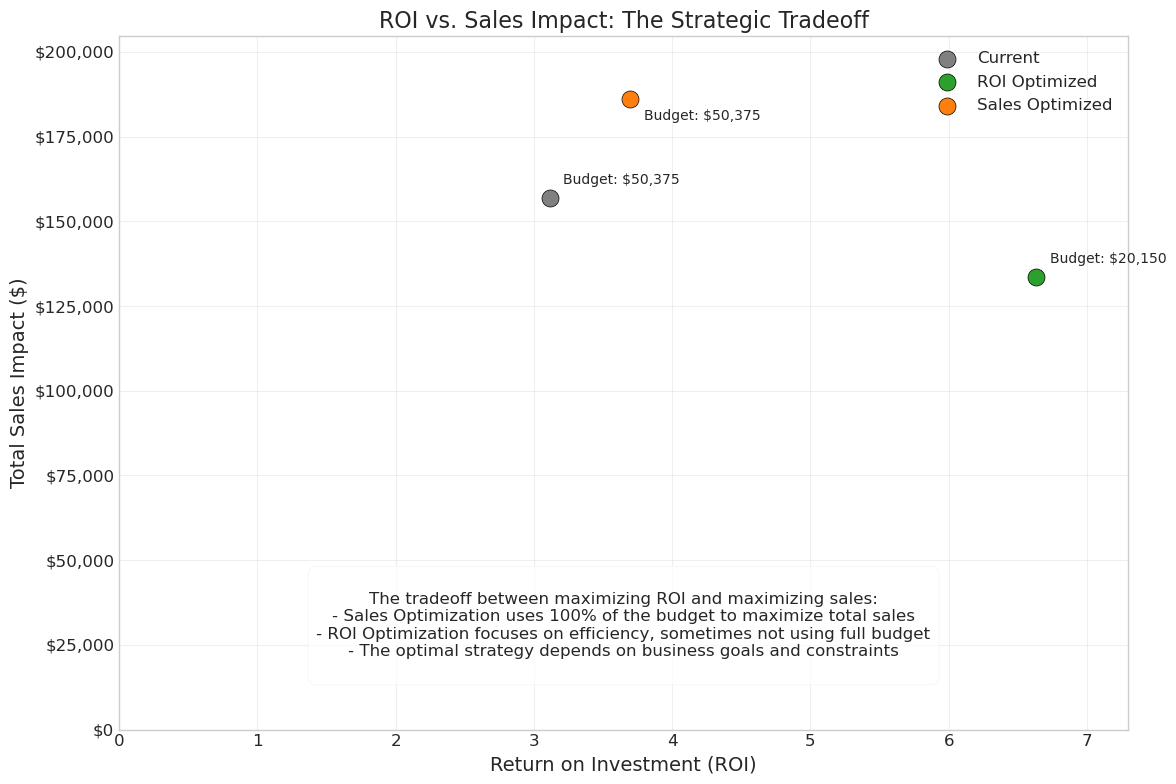

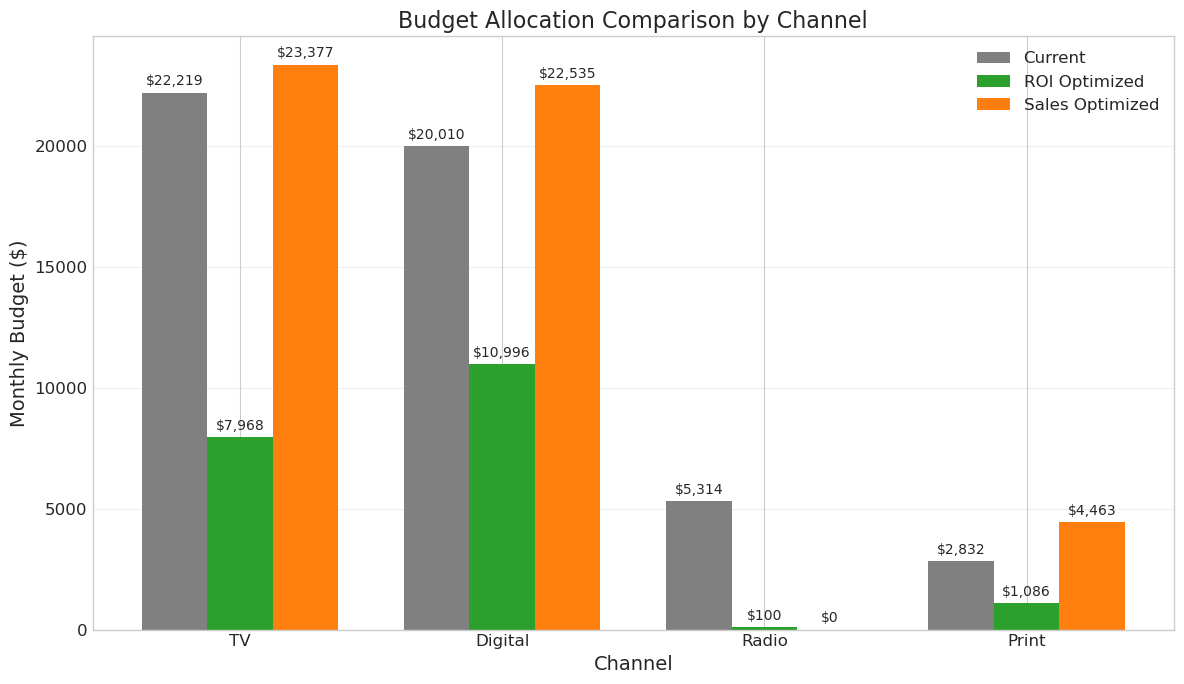


Strategy Comparison Summary:
          Strategy         Budget Used         Sales Impact            ROI
           Current $50,375.03 (100.0%)          $156,792.26           3.11
  ROI Optimization  $20,150.01 (40.0%) $133,647.83 (-14.8%) 6.63 (+113.1%)
Sales Optimization $50,375.03 (100.0%) $186,011.52 (+18.6%)  3.69 (+18.6%)
Comparison table saved to 'optimization_comparison.csv'
HTML comparison table saved to 'optimization_comparison.html'


In [343]:
# COMPLETE VISUALIZATION PACKAGE
# Includes:
# 1. ROI vs Sales tradeoff chart with budget labels
# 2. Bar chart comparing allocations across channels
# 3. Comparison table showing key metrics

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import FuncFormatter

# Get data from current allocation
current_allocation = {}
for channel in channels:
    spend_col = f"{channel}_Spend"
    current_allocation[channel] = data[spend_col].mean()

current_budget = sum(current_allocation.values())
current_impact = predict_sales_impact(current_allocation)
current_roi = current_impact / current_budget

# These variables should already exist from running the ROI optimization
roi_optimized_budget = sum(roi_optimized_allocation.values())
roi_optimized_impact = predict_sales_impact(roi_optimized_allocation) 
roi_optimized_roi = roi_optimized_impact / roi_optimized_budget

# These variables should already exist from running the Sales optimization
sales_optimized_budget = sum(sales_optimized_allocation.values())
sales_optimized_impact = predict_sales_impact(sales_optimized_allocation)
sales_optimized_roi = sales_optimized_impact / sales_optimized_budget

# Print the values to verify
print(f"Current: Budget=${current_budget:.2f}, Impact=${current_impact:.2f}, ROI={current_roi:.2f}")
print(f"ROI Opt: Budget=${roi_optimized_budget:.2f}, Impact=${roi_optimized_impact:.2f}, ROI={roi_optimized_roi:.2f}")
print(f"Sales Opt: Budget=${sales_optimized_budget:.2f}, Impact=${sales_optimized_impact:.2f}, ROI={sales_optimized_roi:.2f}")

# 1. ROI vs Sales tradeoff chart with budget labels
# --------------------------------------------------
plt.figure(figsize=(12, 8))

# Function to format currency values
def currency_formatter(x, pos):
    return f"${x:,.0f}"

# Plot points for the three strategies
plt.scatter([current_roi], [current_impact], s=150, color='gray', 
            marker='o', label='Current', edgecolors='black', zorder=5)
plt.scatter([roi_optimized_roi], [roi_optimized_impact], s=150, color='#2ca02c', 
            marker='o', label='ROI Optimized', edgecolors='black', zorder=5)
plt.scatter([sales_optimized_roi], [sales_optimized_impact], s=150, color='#ff7f0e', 
            marker='o', label='Sales Optimized', edgecolors='black', zorder=5)

# Add budget labels to each point
plt.annotate(f"Budget: ${current_budget:,.0f}", 
             xy=(current_roi, current_impact),
             xytext=(10, 10), textcoords='offset points', fontsize=10)

plt.annotate(f"Budget: ${roi_optimized_budget:,.0f}", 
             xy=(roi_optimized_roi, roi_optimized_impact),
             xytext=(10, 10), textcoords='offset points', fontsize=10)

plt.annotate(f"Budget: ${sales_optimized_budget:,.0f}", 
             xy=(sales_optimized_roi, sales_optimized_impact),
             xytext=(10, -15), textcoords='offset points', fontsize=10)

# Title and labels
plt.title('ROI vs. Sales Impact: The Strategic Tradeoff', fontsize=16)
plt.xlabel('Return on Investment (ROI)', fontsize=14)
plt.ylabel('Total Sales Impact ($)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

# Set axis limits - start y at 0
max_roi = max(current_roi, roi_optimized_roi, sales_optimized_roi) * 1.1
max_sales = max(current_impact, roi_optimized_impact, sales_optimized_impact) * 1.1
plt.xlim(0, max_roi)
plt.ylim(0, max_sales)

# Format y-axis as currency
plt.gca().yaxis.set_major_formatter(FuncFormatter(currency_formatter))

# Add text explaining the tradeoff
text_y = max_sales * 0.15  # Position text at 15% of the max y value
text_x = (max_roi) / 2  # Center the text

explanation = """
The tradeoff between maximizing ROI and maximizing sales:
- Sales Optimization uses 100% of the budget to maximize total sales
- ROI Optimization focuses on efficiency, sometimes not using full budget
- The optimal strategy depends on business goals and constraints
"""

plt.text(text_x, text_y, explanation, ha='center', va='center', 
        bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.5'), fontsize=12)

plt.tight_layout()
plt.savefig('roi_sales_tradeoff_with_budgets.png', dpi=300)
plt.show()

# 2. Bar chart comparing allocations
# ----------------------------------
plt.figure(figsize=(12, 7))

# Data for plotting
channels_plot = channels
current_values = [current_allocation[ch] for ch in channels_plot]
roi_opt_values = [roi_optimized_allocation[ch] for ch in channels_plot]
sales_opt_values = [sales_optimized_allocation[ch] for ch in channels_plot]

# Bar positions
x = np.arange(len(channels_plot))
width = 0.25

# Create bars
bars1 = plt.bar(x - width, current_values, width, label='Current', color='gray')
bars2 = plt.bar(x, roi_opt_values, width, label='ROI Optimized', color='#2ca02c')
bars3 = plt.bar(x + width, sales_opt_values, width, label='Sales Optimized', color='#ff7f0e')

# Add some text for labels, title and axes ticks
plt.xlabel('Channel', fontsize=14)
plt.ylabel('Monthly Budget ($)', fontsize=14)
plt.title('Budget Allocation Comparison by Channel', fontsize=16)
plt.xticks(x, channels_plot, fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3, axis='y')

# Add data labels on top of bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'${height:,.0f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('allocation_comparison.png', dpi=300)
plt.show()

# 3. Comparison table with key metrics
# -----------------------------------
# Calculate percent changes
roi_impact_change = (roi_optimized_impact - current_impact) / current_impact * 100
roi_roi_change = (roi_optimized_roi - current_roi) / current_roi * 100
sales_impact_change = (sales_optimized_impact - current_impact) / current_impact * 100
sales_roi_change = (sales_optimized_roi - current_roi) / current_roi * 100

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Strategy': ['Current', 'ROI Optimization', 'Sales Optimization'],
    'Budget Used': [
        f"${current_budget:,.2f} (100.0%)",
        f"${roi_optimized_budget:,.2f} ({roi_optimized_budget/current_budget*100:.1f}%)",
        f"${sales_optimized_budget:,.2f} (100.0%)"
    ],
    'Sales Impact': [
        f"${current_impact:,.2f}",
        f"${roi_optimized_impact:,.2f} ({roi_impact_change:+.1f}%)",
        f"${sales_optimized_impact:,.2f} ({sales_impact_change:+.1f}%)"
    ],
    'ROI': [
        f"{current_roi:.2f}",
        f"{roi_optimized_roi:.2f} ({roi_roi_change:+.1f}%)",
        f"{sales_optimized_roi:.2f} ({sales_roi_change:+.1f}%)"
    ]
})

# Display the comparison table
print("\nStrategy Comparison Summary:")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)

# Save the comparison table to CSV
comparison_df.to_csv('optimization_comparison.csv', index=False)
print("Comparison table saved to 'optimization_comparison.csv'")

# Optional: Create a styled HTML table for presentations
html_table = comparison_df.to_html(index=False, classes='table table-striped')
with open('optimization_comparison.html', 'w') as f:
    f.write(f"""
    <html>
    <head>
        <style>
            .table {{
                width: 100%;
                border-collapse: collapse;
                font-family: Arial, sans-serif;
            }}
            .table-striped tr:nth-child(even) {{
                background-color: #f2f2f2;
            }}
            th, td {{
                padding: 12px;
                text-align: left;
                border-bottom: 1px solid #ddd;
            }}
            th {{
                background-color: #4CAF50;
                color: white;
            }}
        </style>
    </head>
    <body>
        <h2>Marketing Optimization Strategy Comparison</h2>
        {html_table}
    </body>
    </html>
    """)
print("HTML comparison table saved to 'optimization_comparison.html'")